# Предсказание покупательского поведения на основе данных о предыдущих покупках и маркетенговых коммуникациях

## Введение

### Описание и цель проекта
Проект посвящен анлизу потребительского поведения пользователей интернет-магазина. Цель рооекта предсказать вероятность покупки товара в течение следующих 90 дней, имея исторические данные о покупках и маркетинговых коммуникациях для клиента.

### Описание данных
**История покупок**:
* `client_id` идентификатор пользователя
* `quantity` количество товаров в заказе
* `price` цена товара
* `category_ids` вложенные категории, к которым отнсится товар
* `date` дата покупки
* `message_id` идентификатор сообщения из рассылки

Особенности `category_ids`:
* Данные представляют собой дерево категорий (предполагается вложенность)
* Нумерация категорий сквозная для всех уровней (одинаковая цифровая кодировка на разных позициях вложенности - это один и тот же товар)
* Дерево категорий может обновляться, поэтому могут меняться уровни вложенности

**История рекламных рассылок:**
* `bulk_campaign_id` идентификатор рекламной кампании
* `client_id` идентификатор пользователя
* `message_id` идентификатор сообщений
* `event` тип действия
* `channel` канал рассылки
* `date` дата рассылки
* `created_at` точное время создания сообщения

**Целевой признак (совершит ли клиент покупку в течение следующих 90 дней):**
* `client_id` идентификатор пользователя
* `target` целевой признак

Задача предполагает агрегацию данных на уровне `client_id` для получения признаков, которые могут быть использованы для моделирования.

### Основные этапы исследования
1. Обзор исходных данных
2. Исследовательский анализ исходных данных:
   * Статистический анализ всех признаков
   * Поиск особенностей, которые необходимо учитывать при агрегации данных
3. Создание агрегированных признаков:
   * Создание признака
   * Исследовательский анализ созданных признаков
4. Корреляционный анализ признаков
5. Подготовка данных и выбор оптимальной модели

### Целевая метрика и критерий успеха
$\ ROC-AUC >= 0.7$

In [1]:
import pandas
print('Версия pandas:', pandas.__version__)

Версия pandas: 1.2.4


In [2]:
import numpy
print('Версия catboost:', numpy.__version__)

Версия catboost: 1.24.4


In [3]:
import sklearn
print('Версия sklearn:', sklearn.__version__)

Версия sklearn: 1.6.1


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import seaborn as sns
import math
import phik
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.svm import SVC
import lightgbm as lgb
from sklearn.metrics import (accuracy_score, 
                            precision_score, 
                            recall_score,
                            roc_auc_score
                            )
from sklearn.inspection import permutation_importance
import time
from datetime import datetime

In [6]:
RANDOM_STATE = 42
TEST_SIZE = 0.2

In [7]:
columns_to_russian = {
    'client_id' : ['идентификатор клиента', ''],
    'quantity' : ['количество единиц товара' , ''],
    'price' : ['цена товара', ''],
    'category_ids' : ['идентификаторы категорий', ''],
    'date' : ['дата', ''],
    'message_id' : ['идентификатор сообщения из рассылки', ''],
    'bulk_campaign_id' : ['идентификатор рассылки', ''],
    'event' : ['действие с сообщением', ''],
    'channel' : ['канал рассылки', ''],
    'created_at' : ['дата-время полностью', ''],
    'target' : ['клиент совершил покупку в целевом периоде', ''],
    'year' : ['год', ''],
    'purchases_count' : ['количество покупок', ''],
    'mult_purchases' : ['несколько покупок', ''],
    'revenue' : ['выручка', ''],
    'avg_price' : ['средняя цена товара', ''],
    'fav_cat_2' : ['любимая категория', ''],
    'open_to_send' : ['открытые сообщения к отправленным', ''],
    'click_to_open' : ['клики к открытым сообщениям', ''],
    'purchase_to_click' : ['покупки к кликам', ''],
    'complain' : ['были ли жалобы', ''],
    'hard_bounce' : ['были ли возвраты (hard)', ''],
    'hbq_spam' : ['спам', ''],
    'soft_bounce' : ['были ли возвраты (soft)', ''],
    'subscribe' : ['подписаться', ''],
    'unsubscribe' : ['отписаться', ''],
    'email' : ['доля электронных писем в рассылках', ''],
    'total_messages' : ['общее количество рекламных сообщений', ''],
    'days_from_latest_purchase' : ['дней с последней покупки', ''],
    'negative_event' : ['негативные действия', '']
    
}

In [8]:
def df_overview(df):
    #print('Первые пять строк датафрейма')
    #display(df.head())
    print('\n' + 'Ключевая информация о датафрейме')
    df.info()
    print('\n' + 'Количество пропущенных значений по столбцам')
    display(df.isna().sum())
    print('\n' + 'Описательные статистики')
    display(df.loc[:, (df.columns != 'client_id') & (df.columns != 'bulk_campaign_id')].describe())
    print('\n' + 'Гистограммы для количественных данных')
    try:
        df.loc[:, (df.columns != 'client_id') & (df.columns != 'bulk_campaign_id')].hist(figsize=(15, 3.33 * math.ceil(len(df.select_dtypes(include=np.number).columns.tolist()) / 3))); 
    except:
        print('Нет количественных данных')

In [9]:
def unique_categories(df):
    for col_name in df.select_dtypes(include=['object']).columns.tolist():
        print('Уникальные значения (без учета пропусков) в столбце ' + col_name)
        print(sorted(df[col_name].dropna().unique()), '\n')
        print('\n' + 'Количество уникальных значений (без учета пропусков) в столбце ' + col_name + ':', len(df[col_name].dropna().unique()), '\n')
    

In [10]:
def initial_data_analisys_numeric(df, column_name, split_column = 'None', selected_bins = 150):
    
    print(columns_to_russian[column_name][0] + '(' + columns_to_russian[column_name][1] + ') - описательные статистики' + '\n')
    display(df[column_name].describe())

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,4))
    if split_column == 'None':
        sns.histplot(data = df, x = column_name, ax=ax1, bins = selected_bins)
        sns.boxplot(data = df, x = column_name, orient='h', ax=ax2)
    else:
        sns.histplot(data = df, x = column_name, hue = split_column, bins = selected_bins, ax=ax1)
        sns.boxplot(data = df, x = column_name, y = split_column, orient='h', ax=ax2)
    ax1.set_ylabel('кол-во наблюдений', fontsize=10)
    ax1.set_xlabel(columns_to_russian[column_name][1], fontsize=10)
    ax2.set_ylabel(columns_to_russian[column_name][0], fontsize=10)
    ax2.set_xlabel(columns_to_russian[column_name][1], fontsize=10)
    fig.suptitle(columns_to_russian[column_name][0] + '\n', fontsize = 14)
    plt.show();

In [11]:
def initial_data_analisys_category(df, column_name, target_column = 'None', target_value = 'None'):
    print(columns_to_russian[column_name][0] + ' - количество значений' + '\n')
    display(df.groupby(column_name)[column_name].count().sort_values(ascending = False))

    total_count = df[column_name].count()
    count = df.groupby(column_name)[column_name].count().sort_values(ascending = False)
    share = count.apply(lambda x: 100 * x / total_count)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,4), gridspec_kw={'wspace': 0.3})
    sns.barplot(x = count.values, y = count.index, orient='h', ax = ax1)
    sns.barplot(x = share.values, y = share.index, orient='h', ax = ax2)
    ax1.set_xlabel('кол-во наблюдений', fontsize=10)
    ax1.set_ylabel('')
    ax2.set_xlabel('доля наблюдений, %', fontsize=10)
    ax2.set_ylabel('')
    fig.suptitle(columns_to_russian[column_name][0] + '\n', fontsize = 14)
    plt.show();

    if target_column != 'None':
        target_count = df.groupby(column_name)[target_column].value_counts(normalize=True)
        target_count = target_count.loc[target_count.index.get_level_values(1) == target_value].sort_values(ascending = False).to_frame(name='vals').reset_index()
        fig_2, (ax3, ax4) = plt.subplots(1,2, figsize=(20,4), gridspec_kw={'wspace': 0.3})
        sns.barplot(data = target_count, x = 'vals', y = column_name, orient='h', ax = ax3)
        ax3.set_title(columns_to_russian[column_name][0] + '\n' + 'Значение признака "' + \
                      columns_to_russian[target_column][0] + '" - ' + str(target_value), fontsize = 14)
        ax3.set_xlabel('доля наблюдений от общего кол-ва в категории', fontsize=10)
        ax3.set_ylabel('')
        ax4.axis('off')
        plt.show();

In [12]:
def check_importance(search_result, X_test, y_test, scoring):
    X_test_processed = search_result.best_estimator_.named_steps['preprocessor'].transform(X_test)

    result = permutation_importance(
        search_result.best_estimator_.named_steps['models'], 
        X_test_processed, 
        y_test, 
        n_repeats=10, 
        random_state=RANDOM_STATE,
        scoring = scoring
    )

    sorted_importances_idx = result.importances_mean.argsort()
    importances = pd.DataFrame(
        result.importances[sorted_importances_idx].T,
        columns=search_result.best_estimator_.named_steps['preprocessor'].get_feature_names_out()[sorted_importances_idx],
    )

    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title('Permutation Importance')
    ax.axvline(x=0, color="k", linestyle="--")
    ax.set_xlabel('Изменение метрики');

## Обзор данных

### Импорт данных и проверка корректности загрузки

In [13]:
try:
    df_purchases = pd.read_csv('apparel-purchases.csv')
except:
    print('Файл apparel-purchases.csv не найден')

try:
    df_messages = pd.read_csv('apparel-messages.csv')
except:
    print('Файл apparel-messages.csv не найден')

try:
    df_target = pd.read_csv('apparel-target_binary.csv')
except:
    print('Файл apparel-target_binary.csv не найден')

In [14]:
df_purchases.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [15]:
df_messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [16]:
df_target.head()

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


**Вывод:** данные загружены корректно.

### Основная информация о датафреймах


Ключевая информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB

Количество пропущенных значений по столбцам


client_id       0
quantity        0
price           0
category_ids    0
date            0
message_id      0
dtype: int64


Описательные статистики


,quantity,price
count,202208.000000,202208.000000
mean,1.006483,1193.301516
std,0.184384,1342.252664
min,1.000000,1.000000
25%,1.000000,352.000000
50%,1.000000,987.000000
75%,1.000000,1699.000000
max,30.000000,85499.000000



Гистограммы для количественных данных


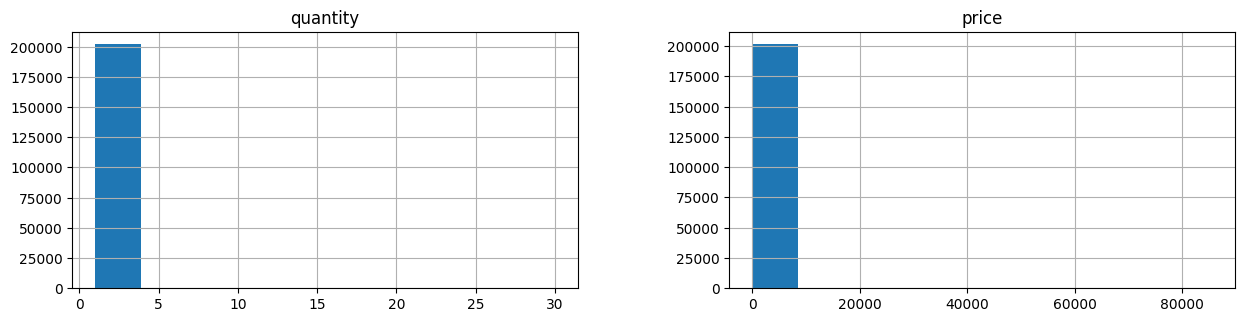

In [17]:
df_overview(df_purchases)

**Вывод:** В истории покупок не наблюдается пропущенных данных, в числовых данных наблюдаются единичные значения, которые значительно отличаются от типичных.

In [18]:
df_overview(df_messages)


Ключевая информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB

Количество пропущенных значений по столбцам


bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64


Описательные статистики


,message_id,event,channel,date,created_at
count,12739798,12739798,12739798,12739798,12739798
unique,9061667,11,2,638,4103539
top,1515915625489095763-6251-6311b13a4cf78,send,mobile_push,2023-06-10,2023-12-29 15:20:53
freq,1454,9058196,7512156,89661,621



Гистограммы для количественных данных
Нет количественных данных


**Вывод:** В истории рекламных рассылок не наблюдается пропущенных данных, все данные являются категориальными.


Ключевая информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB

Количество пропущенных значений по столбцам


client_id    0
target       0
dtype: int64


Описательные статистики


,target
count,49849.000000
mean,0.019278
std,0.137503
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000



Гистограммы для количественных данных


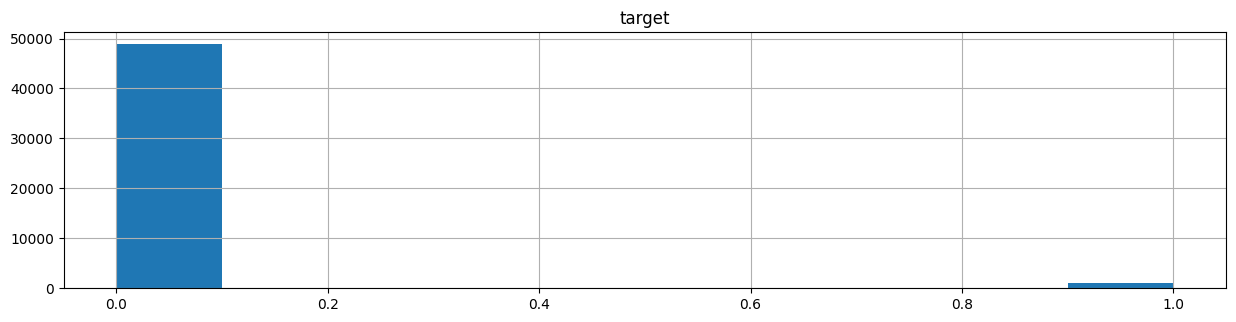

In [19]:
df_overview(df_target)

**Вывод:** В целевом признаке наблюдается значительный дисбаланс классов.

## Исследовательский анализ исходных данных

### `apparel-purchases` - история покупок

#### Полные дубликаты

In [20]:
df_purchases.duplicated().sum()

73020

Можно предположить, что один покупатель в один день совершил несколько покупок одного и того же товара, не будем удалять дубликаты, т.к. удаление приведет с существенному искажению при агрегации.

#### `category_ids` - идентификаторы категорий

**Уникальные значения**

In [21]:
unique_categories(df_purchases.loc[:, ['category_ids']])

Уникальные значения (без учета пропусков) в столбце category_ids
["['1', '22', '50', '685']", "['1', '8', '280', '710']", "['2', '17', '107', '453']", "['2', '17', '137', '469']", "['2', '17', '171', '475']", "['2', '17', '173', '1598']", "['2', '17', '173', '1845']", "['2', '17', '173', '459']", "['2', '17', '180', '465']", "['2', '17', '1826', '1818']", "['2', '17', '188', '525']", "['2', '17', '198', '497']", "['2', '17', '232', '463']", "['2', '17', '279', '5807']", "['2', '17', '286', '455']", "['2', '17', '293', '5819']", "['2', '17', '330', '387', '467']", "['2', '17', '83', '519']", "['2', '17', '83', '5810']", "['2', '18', '123', '451']", "['2', '18', '155', '1325']", "['2', '18', '155', '439']", "['2', '18', '212', '658']", "['2', '18', '212', '659']", "['2', '18', '212', '726']", "['2', '18', '217', '662']", "['2', '18', '217', '663']", "['2', '18', '243', '440']", "['2', '18', '248', '449']", "['2', '18', '248', '677']", "['2', '18', '258', '1195']", "['2', '18', '258', '15

Существует 933 уникальные категории, предварительно большинство из них представляют собой кодировку из 4 чисел, есть записи, категория для которых не известна (`'None'` или пустой список). Проверим количество чисел в `category_ids` для каждой записи.

In [22]:
df_purchases['cat_number'] = df_purchases['category_ids'].apply(lambda x: len(eval(x)))

In [23]:
df_purchases.head(3)

,client_id,quantity,price,category_ids,date,message_id,cat_number
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,4
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,4
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843,4


In [24]:
df_purchases.groupby('cat_number')['client_id'].count()

cat_number
0      5579
1      1264
3      1356
4    193491
5       518
Name: client_id, dtype: int64

Подтверждено, что для абсолютного большинства записей кодировка состоит из 4 чисел. Для унификации категорий проверим возможность приведения всех кодов к формату из 4 чисел.

In [25]:
sorted((df_purchases[df_purchases['cat_number'] == 0]['category_ids']).unique())

['[]']

In [26]:
sorted((df_purchases[df_purchases['cat_number'] == 1]['category_ids']).unique())

['[None]']

Если список в `client_id` состоит из 0 или 1 элементо, значит категоря не известна/пропущена.

In [27]:
sorted((df_purchases[df_purchases['cat_number'] == 5]['category_ids']).unique())

["['2', '17', '330', '387', '467']"]

Есть всего 1 категория, закодированная 5 числами.

In [28]:
len((df_purchases[df_purchases['cat_number'] == 3]['category_ids']).unique())

22

3 числами закодировано ХХ категорий.

In [29]:
len((df_purchases[df_purchases['cat_number'] == 4]['category_ids']).unique())

908

4 числами закодировано 908 категорий.

In [30]:
four_num_categories = sorted((df_purchases[df_purchases['cat_number'] == 4]['category_ids']).unique())

In [31]:
four_num_categories

["['1', '22', '50', '685']",
 "['1', '8', '280', '710']",
 "['2', '17', '107', '453']",
 "['2', '17', '137', '469']",
 "['2', '17', '171', '475']",
 "['2', '17', '173', '1598']",
 "['2', '17', '173', '1845']",
 "['2', '17', '173', '459']",
 "['2', '17', '180', '465']",
 "['2', '17', '1826', '1818']",
 "['2', '17', '188', '525']",
 "['2', '17', '198', '497']",
 "['2', '17', '232', '463']",
 "['2', '17', '279', '5807']",
 "['2', '17', '286', '455']",
 "['2', '17', '293', '5819']",
 "['2', '17', '83', '519']",
 "['2', '17', '83', '5810']",
 "['2', '18', '123', '451']",
 "['2', '18', '155', '1325']",
 "['2', '18', '155', '439']",
 "['2', '18', '212', '658']",
 "['2', '18', '212', '659']",
 "['2', '18', '212', '726']",
 "['2', '18', '217', '662']",
 "['2', '18', '217', '663']",
 "['2', '18', '243', '440']",
 "['2', '18', '248', '449']",
 "['2', '18', '248', '677']",
 "['2', '18', '258', '1195']",
 "['2', '18', '258', '1561']",
 "['2', '18', '258', '1562']",
 "['2', '18', '258', '1569']",
 "

Среди уникальных значений кодов, состоящих из 4 чисел, нет аналога категории ['2', '17', '330', '387', '467'], поэтому не будем ее преобразовывать (оставим код из 5 чисел в виде исключения).

Подход к обработке данных:
* унифицировать кодировку для неизвестной категории
* коды из 3 чисел привести к кодам из 4 чисел (если код из 3 чисел полностью входит в код из 4 чисел, его можно заменить на соответствующий код из 4 чисел)

In [32]:
def convert_to_4_num_categories(x):
    item = eval(x)
    if len(item) < 3:
        return str(['None'])
    elif len(item) > 3:
        return x
    else:
        for cat in four_num_categories:
            if set(item).issubset(set(eval(cat))):
                return cat
        item.append('0')
        return str(item)

In [33]:
df_purchases['category_ids_upd'] = df_purchases['category_ids'].apply(convert_to_4_num_categories)

Проверка:

In [34]:
df_purchases[(df_purchases['cat_number'] == 0) | (df_purchases['cat_number'] == 1)]

,client_id,quantity,price,category_ids,date,message_id,cat_number,category_ids_upd
14848,1515915625649908756,1,2499.0,[None],2022-06-17,1515915625649908756-4981-62ac2dbf52fad,1,['None']
22153,1515915625558323436,1,1.0,[],2022-07-09,1515915625487742246-5335-62c7d2d1281c7,0,['None']
22154,1515915625558323436,1,1.0,[],2022-07-09,1515915625487742246-5335-62c7d2d1281c7,0,['None']
32281,1515915625578652401,1,8.0,[None],2022-08-19,1515915625815834300-5922-62ff35494e05f,1,['None']
32282,1515915625578652401,1,8.0,[None],2022-08-19,1515915625815834300-5922-62ff35494e05f,1,['None']
...,...,...,...,...,...,...,...,...
201990,1515915625641742458,1,7.0,[],2024-02-16,1515915625766077627-14668-65cf5246bd490,0,['None']
202068,1515915625955716904,1,7.0,[],2024-02-16,1515915625955716904-14668-65cf5252e767c,0,['None']
202069,1515915625955716904,1,7.0,[],2024-02-16,1515915625955716904-14668-65cf5252e767c,0,['None']
202144,1515915626007712189,1,12.0,[],2024-02-16,1515915626007712189-14648-65cdb6d1c0c2a,0,['None']


In [35]:
df_purchases[(df_purchases['cat_number'] == 3)]

,client_id,quantity,price,category_ids,date,message_id,cat_number,category_ids_upd
55348,1515915625489465791,1,193.0,"['4', '44', '428']",2022-11-15,1515915625489465791-7845-6373358bbb68e,3,"['4', '28', '44', '428']"
55349,1515915625489465791,1,193.0,"['4', '44', '428']",2022-11-15,1515915625489465791-7845-6373358bbb68e,3,"['4', '28', '44', '428']"
56942,1515915625602272264,1,28.0,"['4', '44', '1594']",2022-11-15,1515915625491914808-7845-637335966f02d,3,"['4', '28', '44', '1594']"
56943,1515915625602272264,1,28.0,"['4', '44', '1594']",2022-11-15,1515915625491914808-7845-637335966f02d,3,"['4', '28', '44', '1594']"
57592,1515915625468142032,1,39.0,"['4', '44', '1594']",2022-11-16,1515915625468142032-7816-6371eb13cdaed,3,"['4', '28', '44', '1594']"
...,...,...,...,...,...,...,...,...
201643,1515915625585044070,1,199.0,"['4', '44', '430']",2024-02-15,1515915625585044070-14656-65cdbea44cf9e,3,"['4', '28', '44', '430']"
202022,1515915625780975466,1,69.0,"['4', '44', '491']",2024-02-16,1515915625780975466-14648-65cdb6ee6aaf8,3,"['4', '28', '44', '491']"
202023,1515915625780975466,1,69.0,"['4', '44', '491']",2024-02-16,1515915625780975466-14648-65cdb6ee6aaf8,3,"['4', '28', '44', '491']"
202028,1515915625785777568,1,99.0,"['4', '29', '503']",2024-02-16,1515915625785777568-14628-65c9ec6d23ac1,3,"['4', '29', '503', '0']"


In [36]:
df_purchases[df_purchases['cat_number'] == 5]

,client_id,quantity,price,category_ids,date,message_id,cat_number,category_ids_upd
1703,1515915625605245612,1,1499.0,"['2', '17', '330', '387', '467']",2022-05-20,1515915625605245612-4492-62873cca6dd23,5,"['2', '17', '330', '387', '467']"
1727,1515915625637984750,1,1599.0,"['2', '17', '330', '387', '467']",2022-05-20,1515915625637984750-4492-62873cd797f2a,5,"['2', '17', '330', '387', '467']"
2093,1515915625642188604,1,1799.0,"['2', '17', '330', '387', '467']",2022-05-21,1515915625557272200-3557-623d68b1ecb7f,5,"['2', '17', '330', '387', '467']"
2794,1515915625623306912,1,999.0,"['2', '17', '330', '387', '467']",2022-05-23,1515915625623306912-4492-62873cd587294,5,"['2', '17', '330', '387', '467']"
4827,1515915625487831171,1,4499.0,"['2', '17', '330', '387', '467']",2022-06-01,1515915625487831171-4679-62972204a71a4,5,"['2', '17', '330', '387', '467']"
...,...,...,...,...,...,...,...,...
198902,1515915625659732968,1,754.0,"['2', '17', '330', '387', '467']",2024-02-03,1515915625659732968-14587-65bcc241ac42f,5,"['2', '17', '330', '387', '467']"
200094,1515915625552725873,1,899.0,"['2', '17', '330', '387', '467']",2024-02-10,1515915625491406267-14625-65c5ed5d6dba4,5,"['2', '17', '330', '387', '467']"
200095,1515915625552725873,1,899.0,"['2', '17', '330', '387', '467']",2024-02-10,1515915625491406267-14625-65c5ed5d6dba4,5,"['2', '17', '330', '387', '467']"
201516,1515915626004250531,1,700.0,"['2', '17', '330', '387', '467']",2024-02-14,1515915626004250531-14633-65c9c9a725b04,5,"['2', '17', '330', '387', '467']"


Данные обработаны корректно в соответствии с выбранным подходом.

Создадим в качестве дополнительного признака кодировку товара, урезанную до 2 чисел (более высокий уровень вложенности).

In [37]:
df_purchases['category_ids_2_num'] = df_purchases['category_ids_upd'].apply(lambda x: str(eval(x)[:2]))

In [38]:
df_purchases.sample(10)

,client_id,quantity,price,category_ids,date,message_id,cat_number,category_ids_upd,category_ids_2_num
114181,1515915625544623770,1,1749.0,"['4', '28', '260', '420']",2023-04-29,1515915625764200684-12218-644b830d384a7,4,"['4', '28', '260', '420']","['4', '28']"
92621,1515915625590794765,1,1679.0,"['4', '28', '62', '657']",2023-03-18,1515915625470655001-10988-64141027d9d62,4,"['4', '28', '62', '657']","['4', '28']"
22552,1515915625558249825,1,599.0,"['2', '17', '180', '465']",2022-07-10,1515915625558249825-5335-62c7d2ad8c429,4,"['2', '17', '180', '465']","['2', '17']"
87315,1515915625535930052,1,1400.0,"['4', '28', '58', '434']",2023-03-03,1515915625535930052-10619-6401de4cb070e,4,"['4', '28', '58', '434']","['4', '28']"
166786,1515915625579582262,1,1299.0,"['2', '18', '155', '439']",2023-08-28,1515915625864888670-13732-64ec6f9369979,4,"['2', '18', '155', '439']","['2', '18']"
4364,1515915625658877925,1,2399.0,"['4', '28', '260', '420']",2022-05-30,1515915625658877925-4617-6290658440faa,4,"['4', '28', '260', '420']","['4', '28']"
103179,1515915625798845845,1,1399.0,"['2', '18', '258', '441']",2023-04-13,1515915625468141914-11760-6436739add08f,4,"['2', '18', '258', '441']","['2', '18']"
73449,1515915625893290191,1,69.0,"['5562', '5634', '5650', '712']",2022-12-21,1515915625893290191-8902-63a2cf0f74f0e,4,"['5562', '5634', '5650', '712']","['5562', '5634']"
86083,1515915625559869572,1,279.0,"['2', '18', '267', '442']",2023-02-23,1515915625559868813-10373-63f5cbc4dbc28,4,"['2', '18', '267', '442']","['2', '18']"
30437,1515915625766002765,1,1299.0,"['4', '27', '1828', '5803']",2022-08-08,1515915625766002765-5894-62f11a790ab1d,4,"['4', '27', '1828', '5803']","['4', '27']"


In [39]:
unique_categories(df_purchases.loc[:, ['category_ids_upd', 'category_ids_2_num']])

Уникальные значения (без учета пропусков) в столбце category_ids_upd
["['1', '22', '50', '685']", "['1', '8', '280', '710']", "['2', '17', '107', '453']", "['2', '17', '137', '469']", "['2', '17', '171', '475']", "['2', '17', '173', '1598']", "['2', '17', '173', '1845']", "['2', '17', '173', '459']", "['2', '17', '180', '465']", "['2', '17', '1826', '1818']", "['2', '17', '188', '525']", "['2', '17', '198', '497']", "['2', '17', '232', '463']", "['2', '17', '279', '5807']", "['2', '17', '286', '455']", "['2', '17', '293', '5819']", "['2', '17', '330', '387', '467']", "['2', '17', '83', '519']", "['2', '17', '83', '5810']", "['2', '18', '123', '451']", "['2', '18', '155', '1325']", "['2', '18', '155', '439']", "['2', '18', '212', '658']", "['2', '18', '212', '659']", "['2', '18', '212', '726']", "['2', '18', '217', '662']", "['2', '18', '217', '663']", "['2', '18', '243', '440']", "['2', '18', '248', '449']", "['2', '18', '248', '677']", "['2', '18', '258', '1195']", "['2', '18', '258',

После обработки данных существует 916 уникальных категорий на уровне 4-чиселной кодировки и 32 унакальные категории на уровне 2-чисельной кодировки.

#### `quantity` - количество единиц товара

количество единиц товара() - описательные статистики



count    202208.000000
mean          1.006483
std           0.184384
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          30.000000
Name: quantity, dtype: float64

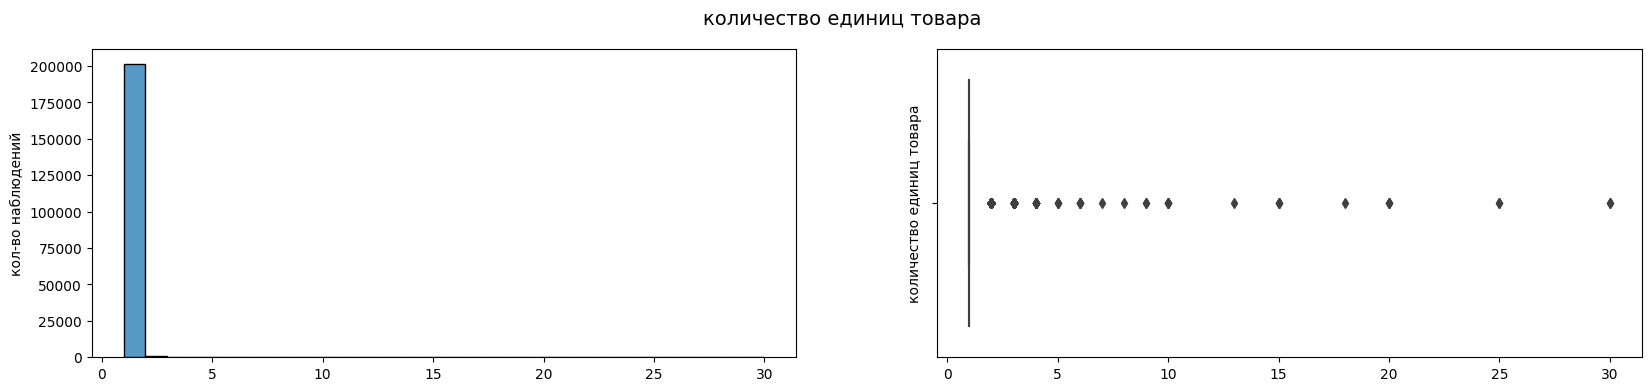

In [40]:
initial_data_analisys_numeric(df_purchases, 'quantity', selected_bins = 30)

количество единиц товара - количество значений



quantity
1     201323
2        751
3         94
4         12
6          5
10         4
5          3
15         3
20         3
9          2
25         2
30         2
7          1
8          1
13         1
18         1
Name: quantity, dtype: int64

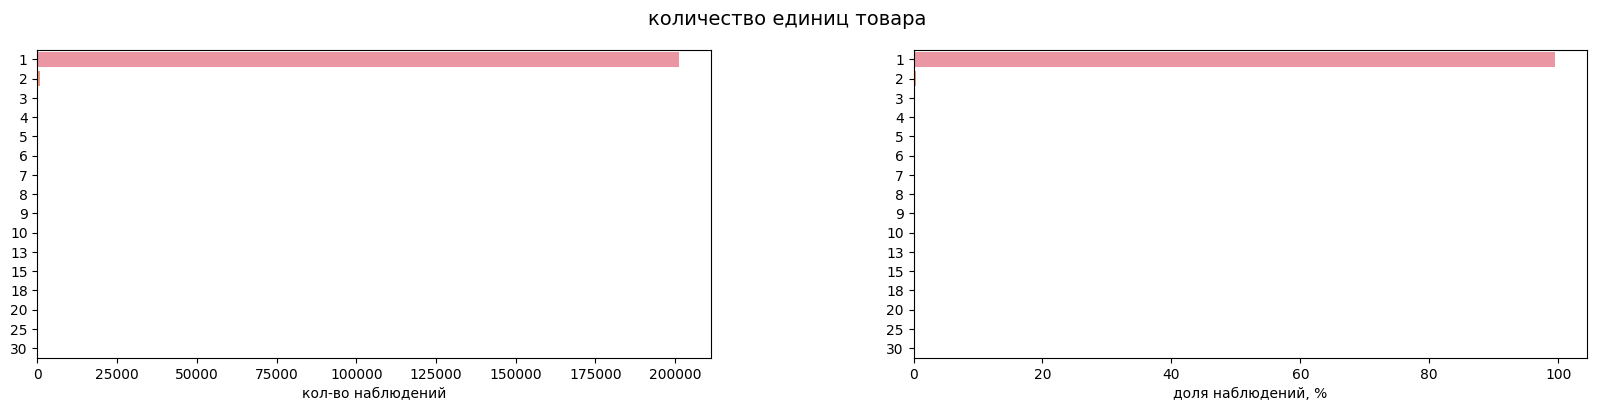

In [41]:
initial_data_analisys_category(df_purchases, 'quantity')

Практически во всех случаях покупка включает 1 единицу товара.

#### `price` - цена товара

цена товара() - описательные статистики



count    202208.000000
mean       1193.301516
std        1342.252664
min           1.000000
25%         352.000000
50%         987.000000
75%        1699.000000
max       85499.000000
Name: price, dtype: float64

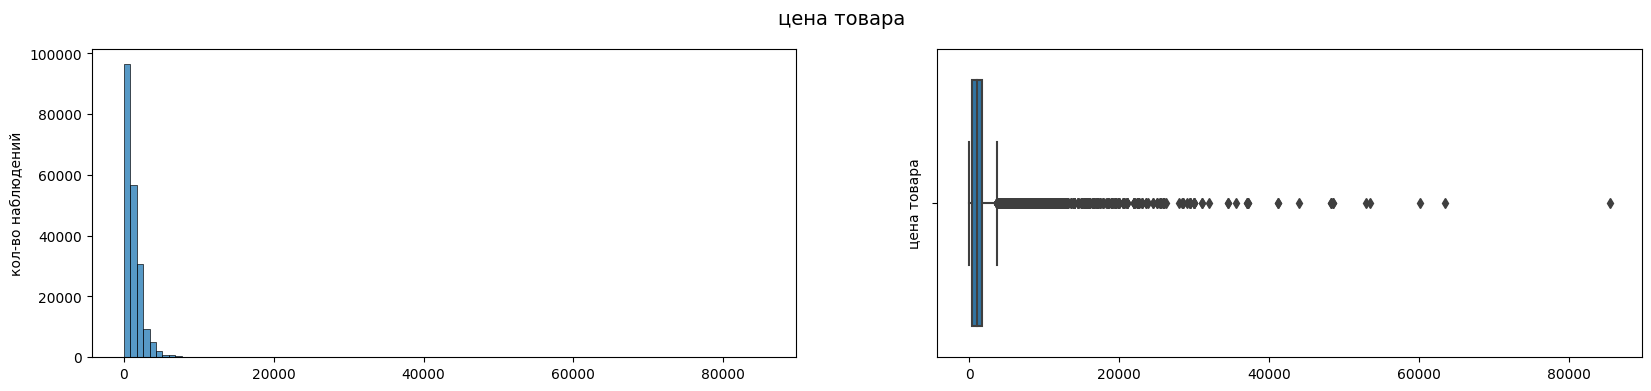

In [42]:
initial_data_analisys_numeric(df_purchases, 'price', selected_bins = 100)

In [43]:
df_purchases['price'].quantile(0.99)

5499.0

В 99% случаев цена товара не превышает 5500 ед.

цена товара() - описательные статистики



count    200442.000000
mean       1126.009943
std         992.401218
min           1.000000
25%         350.000000
50%         954.000000
75%        1680.000000
max        5499.000000
Name: price, dtype: float64

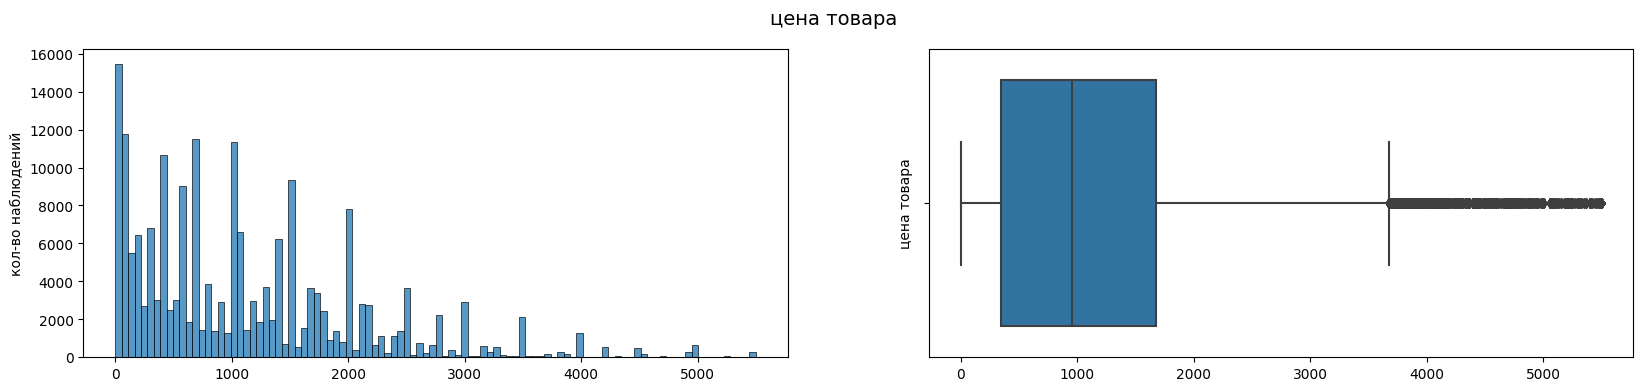

In [44]:
initial_data_analisys_numeric(df_purchases[df_purchases['price'] < 5500], 'price', selected_bins = 100)

#### `date` - дата покупки

In [45]:
df_purchases['year'] = df_purchases['date'].apply(lambda x: int(x[0:4]))

год - количество значений



year
2023    109680
2022     81621
2024     10907
Name: year, dtype: int64

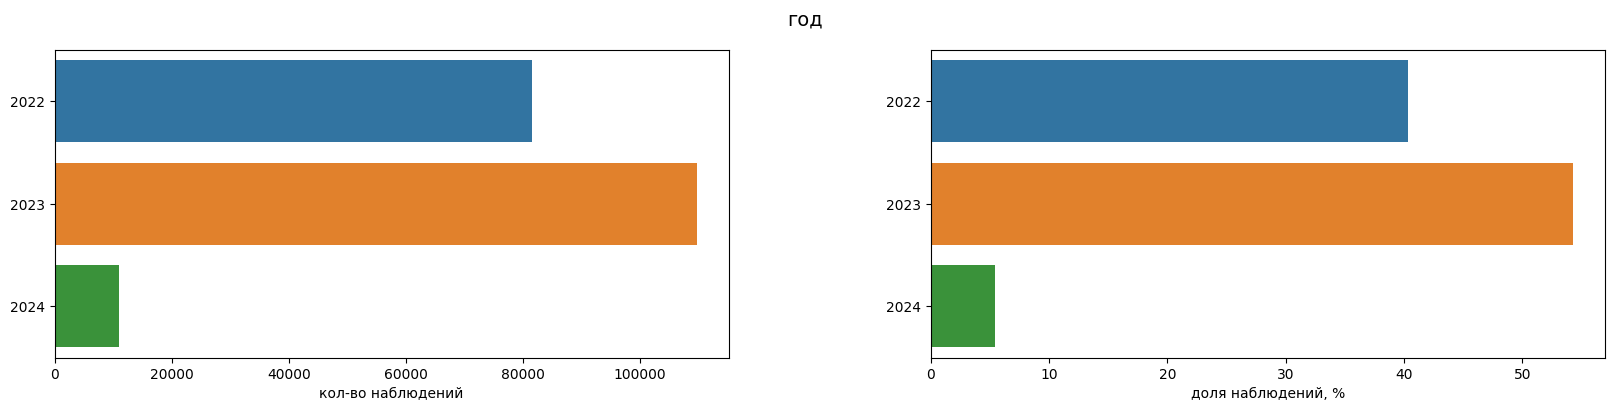

In [46]:
initial_data_analisys_category(df_purchases, 'year')

In [47]:
df_purchases['date'].min()

'2022-05-16'

In [48]:
df_purchases['date'].max()

'2024-02-16'

Датафрейм содержит данные с 16.05.2022 по 16.02.2024. Большинство покупок покрывают 2023 г.

### `apparel-messages` - история рекламных рассылок

#### Полные дубликаты

In [49]:
df_messages.duplicated().sum()

48610

Датафрейм содержит значительное число полных дубликатов. Удалим их, т.к. в данных содержится дата и время с точностью до секунды. Будем считать, что одно и то же событие не может произойти более 1 раза за секунду.

In [50]:
df_messages = df_messages.drop_duplicates()
df_messages.duplicated().sum()

0

Дубликаты успешно удалены.

#### `event` - тип действия

действие с сообщением - количество значений



event
send           9058174
open           3052481
click           483326
purchase         62593
hard_bounce      19763
soft_bounce      10582
unsubscribe       2833
hbq_spam           823
complain           527
subscribe           85
close                1
Name: event, dtype: int64

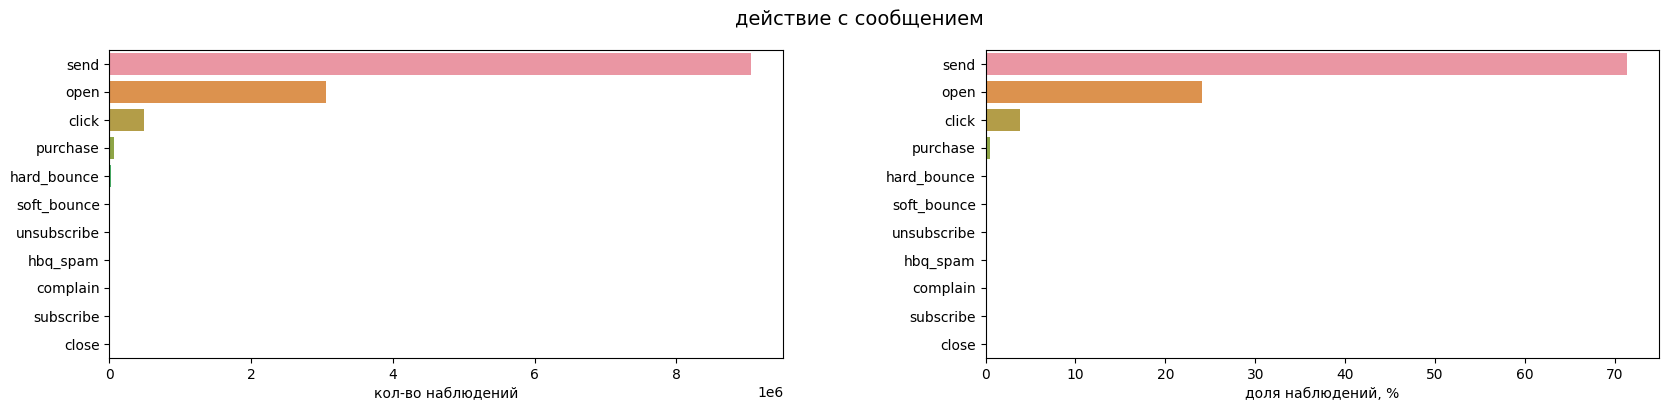

In [51]:
initial_data_analisys_category(df_messages, 'event')

Данные содержат 11 различных действий для сообщения. Все действия условно можно разделить на положительные (прим. `'open'`, `'click'`, `'purchase'`) и негативные (прим. `'hard_bounce'`, `'soft_bounce'`, `'hbq_spam'`). Негативные действия являются относительно редкими.

**Последовательность действий**

In [52]:
df_messages[df_messages.duplicated(subset = ['client_id', 'message_id'], keep= False)].sort_values(by = ['client_id', 'message_id'])

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
4459127,11144,1515915625468060902,1515915625468060902-11144-641ad1d82ed4a,send,email,2023-03-22,2023-03-22 10:13:09
4500940,11144,1515915625468060902,1515915625468060902-11144-641ad1d82ed4a,open,email,2023-03-22,2023-03-22 21:20:38
4753519,11855,1515915625468060902,1515915625468060902-11855-643933087349d,send,email,2023-04-14,2023-04-14 11:20:37
4775295,11855,1515915625468060902,1515915625468060902-11855-643933087349d,open,email,2023-04-14,2023-04-14 19:16:35
6274702,13505,1515915625468060902,1515915625468060902-13505-64b505ec31131,send,email,2023-07-17,2023-07-17 09:27:57
...,...,...,...,...,...,...,...
12707790,14648,1515915626010261344,1515915626010261344-14648-65cdb6d56c4c8,send,mobile_push,2024-02-15,2024-02-15 07:08:21
12707814,14648,1515915626010261344,1515915626010261344-14648-65cdb6d56c4c8,open,mobile_push,2024-02-15,2024-02-15 07:08:38
12739397,14648,1515915626010261344,1515915626010261344-14648-65cdb6d56c4c8,click,mobile_push,2024-02-15,2024-02-15 16:23:39
12707477,14648,1515915626010288690,1515915626010288690-14648-65cdb6d29b698,send,mobile_push,2024-02-15,2024-02-15 07:04:47


Обратим внимание, что при заданном `client_id` и `message_id` может быть несколько действий, т.е. потенциального для каждого сообщения можно проследить полную последовательность действий от отправки до покупки (при реализации наиболее благоприятного сценария).

#### `channel` - канал рассылки

канал рассылки - количество значений



channel
mobile_push    7470472
email          5220716
Name: channel, dtype: int64

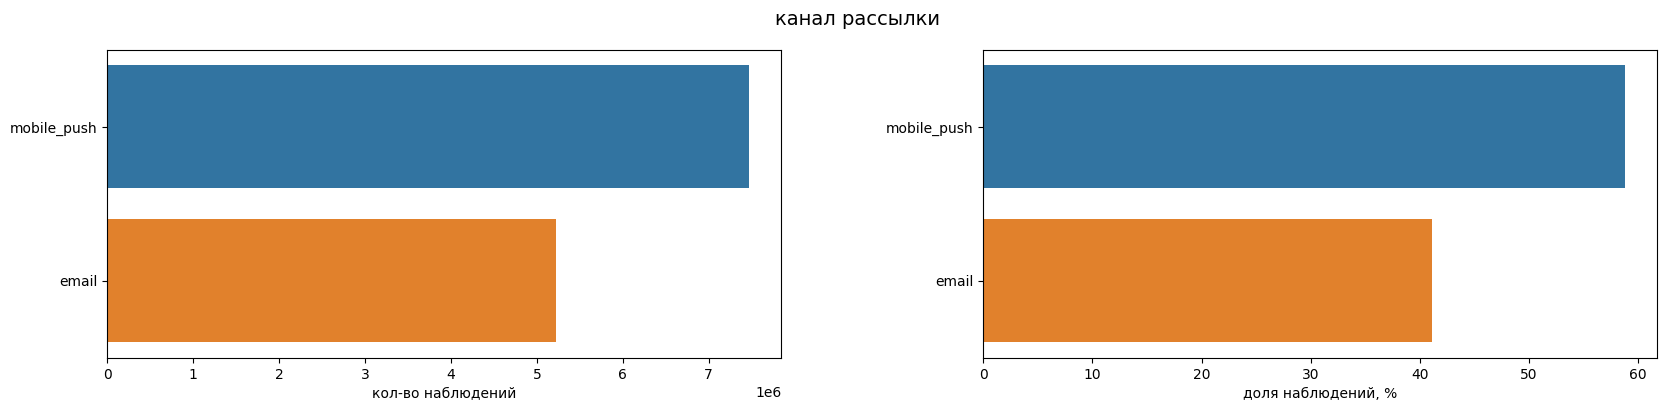

In [53]:
initial_data_analisys_category(df_messages, 'channel')

Выявлено 2 канала доставки рекламных сообщений: электронная почта (40%) и пуш-уведомления (60%).

#### `date` - дата рассылки

In [54]:
df_messages['year'] = df_messages['date'].apply(lambda x: int(x[0:4]))

год - количество значений



year
2023    7628148
2022    3454342
2024    1608698
Name: year, dtype: int64

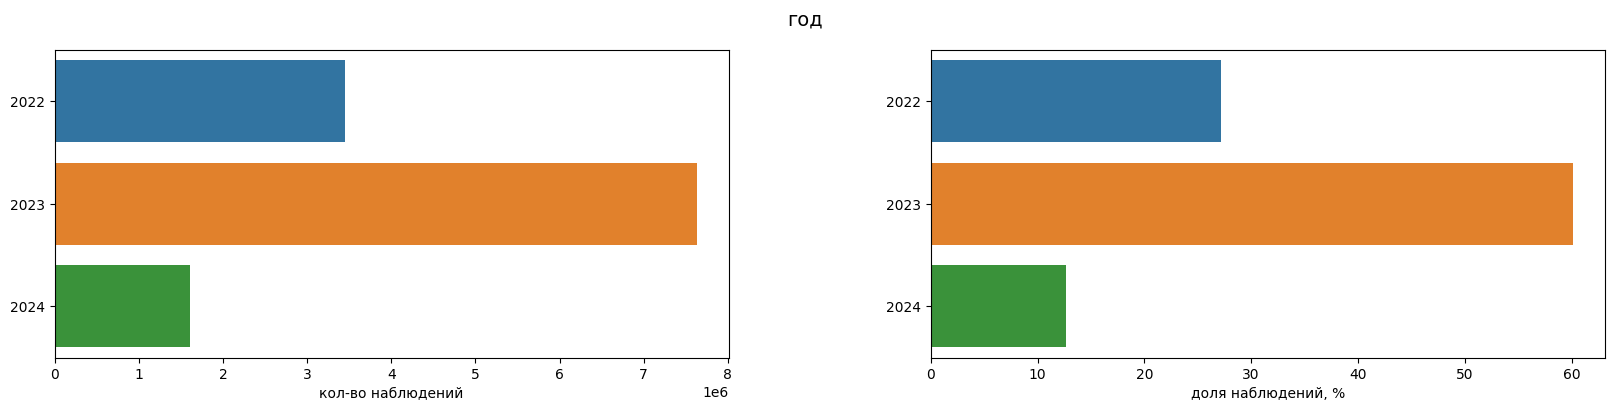

In [55]:
initial_data_analisys_category(df_messages, 'year')

In [56]:
df_messages['date'].min()

'2022-05-19'

In [57]:
df_messages['date'].max()

'2024-02-15'

Датафрейм содержит данные с 19.05.2022 по 15.02.2024. Большинство покупок покрывают 2023 г., что с погрешностью 1-2 дня соответствует периоду, закоторый собраны данные о покупках, таким образом данные о покупках и рекламной коммуникации можно рассматривать совместно.

### `apparel-target_binary` - покупка в течение следующих 90 дней

#### `target` - целевой признак

In [58]:
df_target.duplicated().sum()

0

клиент совершил покупку в целевом периоде - количество значений



target
0    48888
1      961
Name: target, dtype: int64

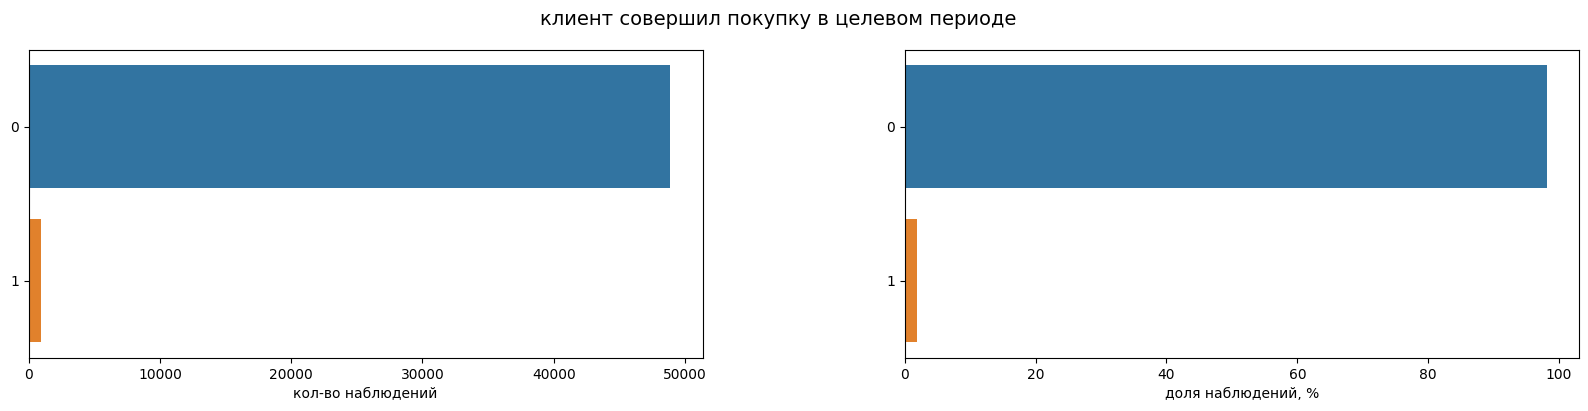

In [59]:
initial_data_analisys_category(df_target, 'target')

Полные дубликаты отсутствуют, при моделировании необходимо учитывать дисбаланс классов.

## Агрегированные данные по клиентам

### Создание признаков и исследовательский анализ признаков

#### Характеристики покупок клиента

* суммарное количество единиц товара
* общее количество покупок (покупка определяется по уникальной дате)
* суммарная выручка по клиенту

In [60]:
df_purchases['revenue'] = df_purchases['quantity'] * df_purchases['price']

In [61]:
df_purchases_agg = df_purchases.groupby('client_id').agg({
    'quantity' : 'sum',
    'date' : 'nunique',
    'revenue' : 'sum'
}).reset_index()

In [62]:
df_purchases_agg.head()

,client_id,quantity,date,revenue
0,1515915625468060902,7,1,6993.0
1,1515915625468061003,7,1,16235.0
2,1515915625468061099,1,1,299.0
3,1515915625468061100,2,1,2098.0
4,1515915625468061170,19,3,33601.0


In [63]:
df_purchases_agg.rename(columns={'date':'purchases_count'}, inplace=True)
df_purchases_agg.head()

,client_id,quantity,purchases_count,revenue
0,1515915625468060902,7,1,6993.0
1,1515915625468061003,7,1,16235.0
2,1515915625468061099,1,1,299.0
3,1515915625468061100,2,1,2098.0
4,1515915625468061170,19,3,33601.0


Соединим новые признаки с таргетом и проведем исследовательский анализ.

In [64]:
df_target = df_target.merge(df_purchases_agg, on = 'client_id', how = 'left')
df_target.head()

,client_id,target,quantity,purchases_count,revenue
0,1515915625468060902,0,7,1,6993.0
1,1515915625468061003,1,7,1,16235.0
2,1515915625468061099,0,1,1,299.0
3,1515915625468061100,0,2,1,2098.0
4,1515915625468061170,0,19,3,33601.0


**`quantity` - общее количество товаров**

количество единиц товара() - описательные статистики



count    49849.000000
mean         4.082710
std          5.562927
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        355.000000
Name: quantity, dtype: float64

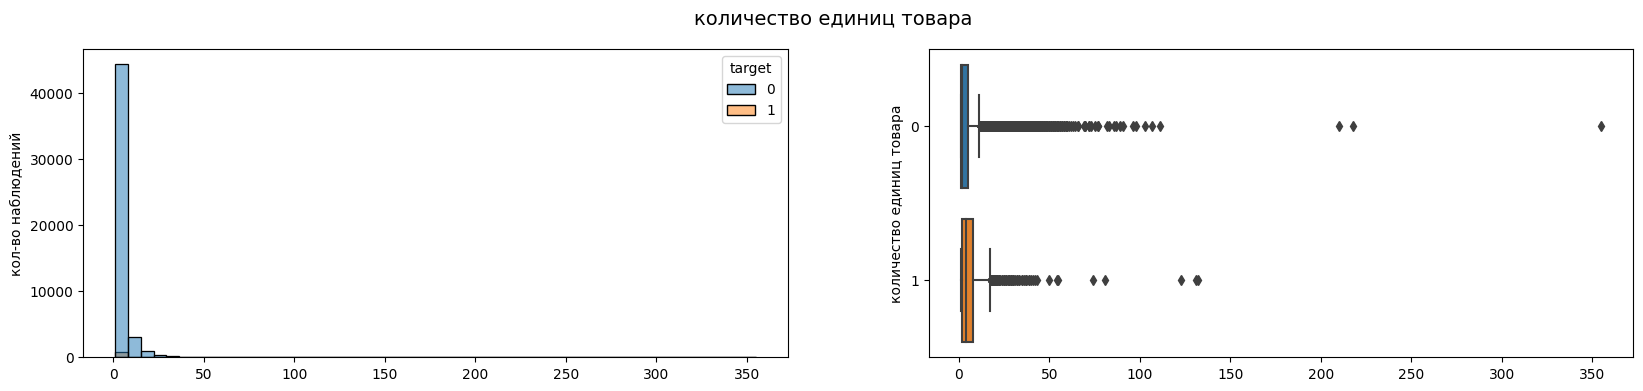

In [65]:
initial_data_analisys_numeric(df_target, 'quantity', split_column = 'target', selected_bins = 50)

количество единиц товара() - описательные статистики



count    49777.000000
mean         3.979147
std          4.536572
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max         49.000000
Name: quantity, dtype: float64

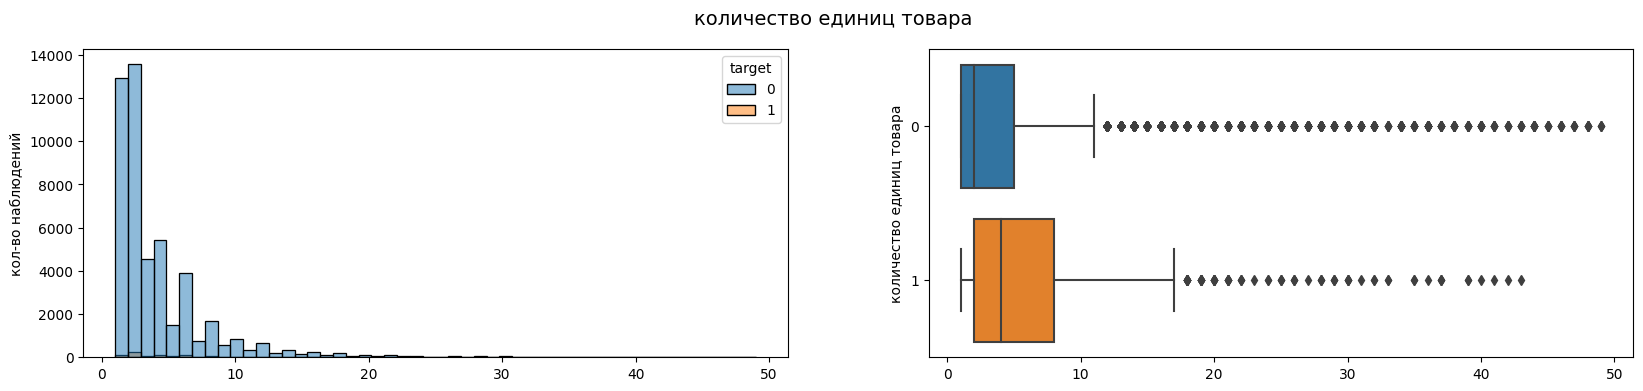

In [66]:
initial_data_analisys_numeric(df_target[df_target['quantity'] < 50], 'quantity', split_column = 'target', selected_bins = 50)

**`purchases_count` - общее количество покупок**

количество покупок() - описательные статистики



count    49849.000000
mean         1.207808
std          0.665728
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         41.000000
Name: purchases_count, dtype: float64

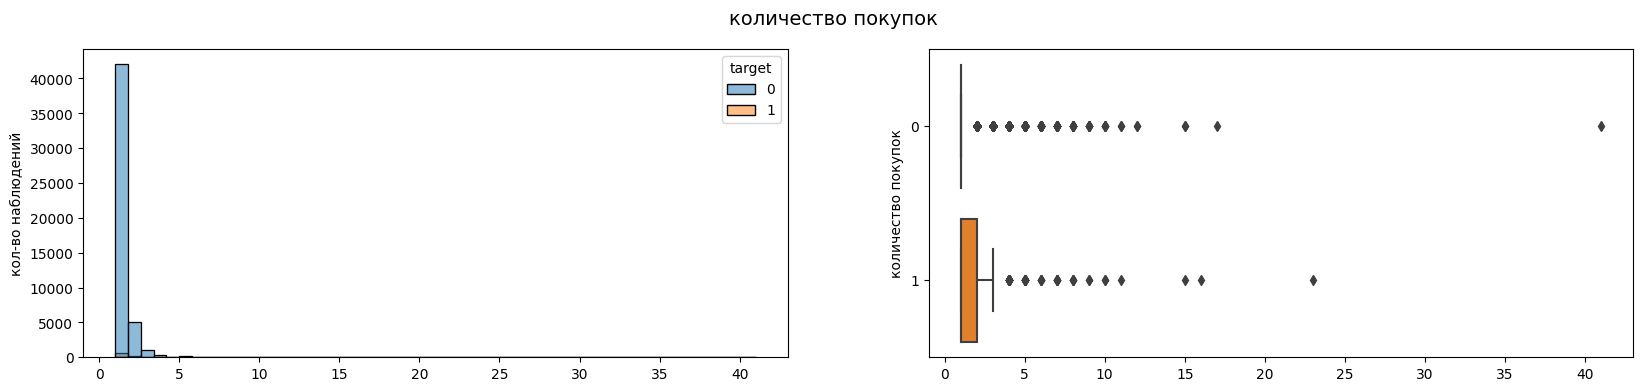

In [67]:
initial_data_analisys_numeric(df_target, 'purchases_count', split_column = 'target', selected_bins = 50)

**`mult_purchases` - более одной покупки**

Создадим дополнительный признак - несколько покупок:
* `'0'` - покупатель совершил одну покупку (есть одна уникальная дата покупки)
* `'1'` - покупатель совершил несколько покупок

In [68]:
df_target['mult_purchases'] = df_target['purchases_count'].apply(lambda x: 1 if x > 1 else 0)

несколько покупок - количество значений



mult_purchases
0    42706
1     7143
Name: mult_purchases, dtype: int64

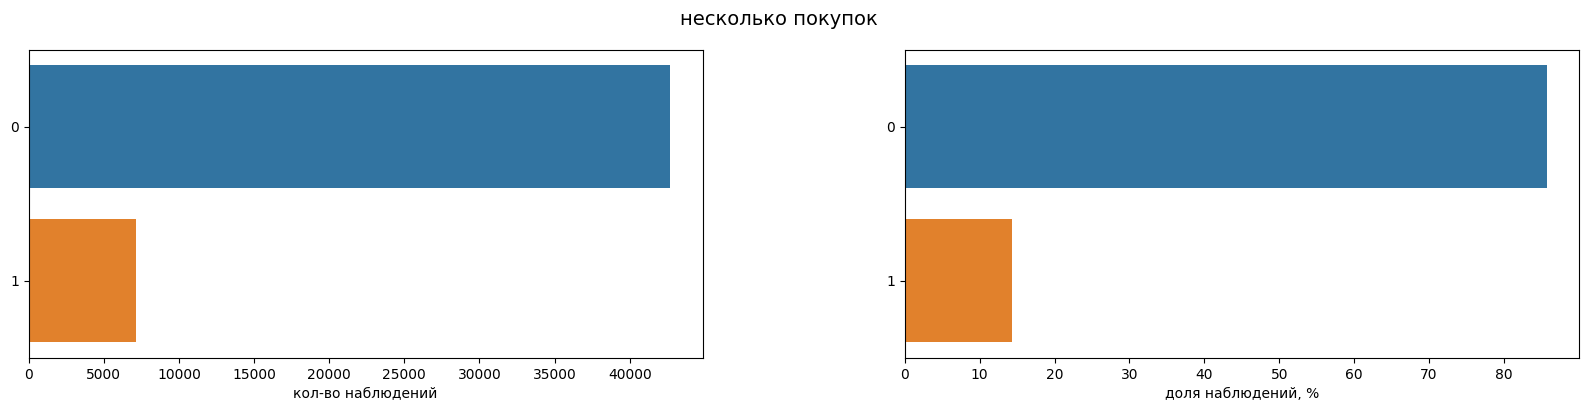

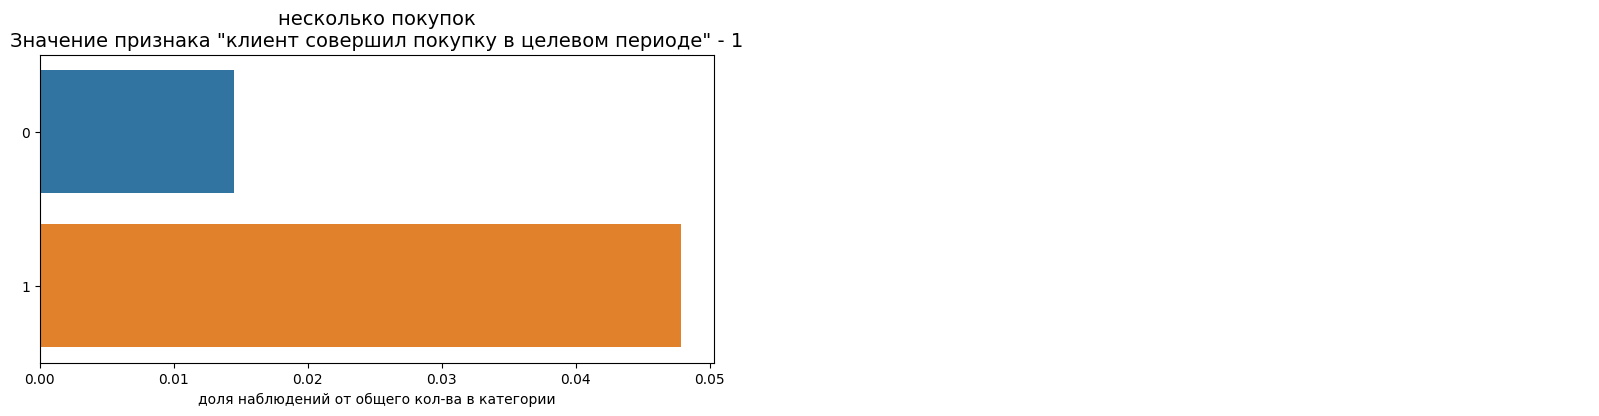

In [69]:
initial_data_analisys_category(df_target, 'mult_purchases', target_column = 'target', target_value = 1)

**`revenue` - суммарная выручка** 

выручка() - описательные статистики



count     49849.000000
mean       4865.584264
std        7351.467229
min           1.000000
25%        1499.000000
50%        2969.000000
75%        5698.000000
max      540408.000000
Name: revenue, dtype: float64

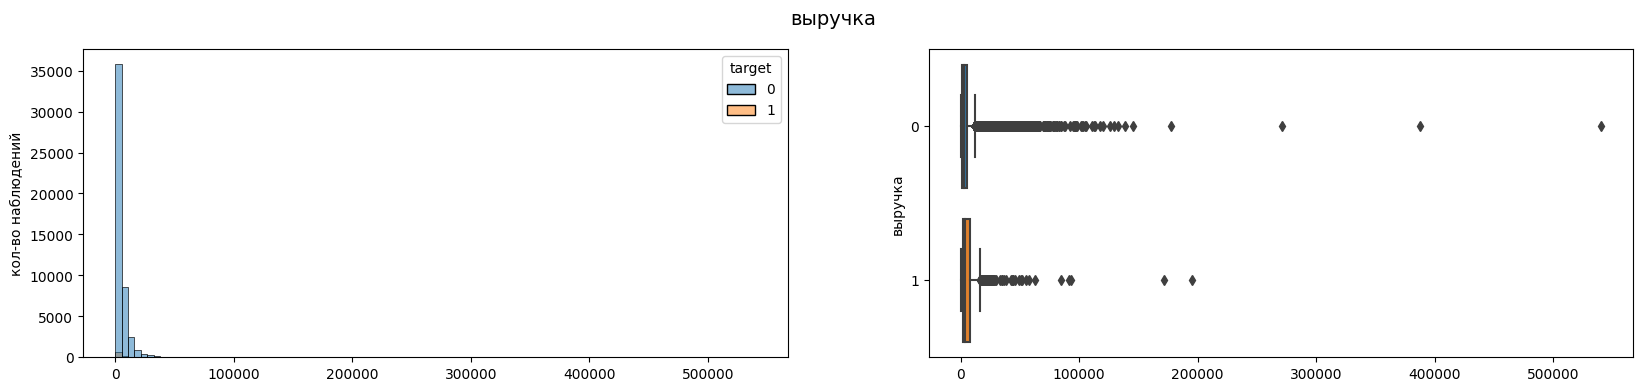

In [70]:
initial_data_analisys_numeric(df_target, 'revenue', split_column = 'target', selected_bins = 100)

выручка() - описательные статистики



count    48508.000000
mean      4057.249402
std       3670.200175
min          1.000000
25%       1499.000000
50%       2799.000000
75%       5398.000000
max      19999.000000
Name: revenue, dtype: float64

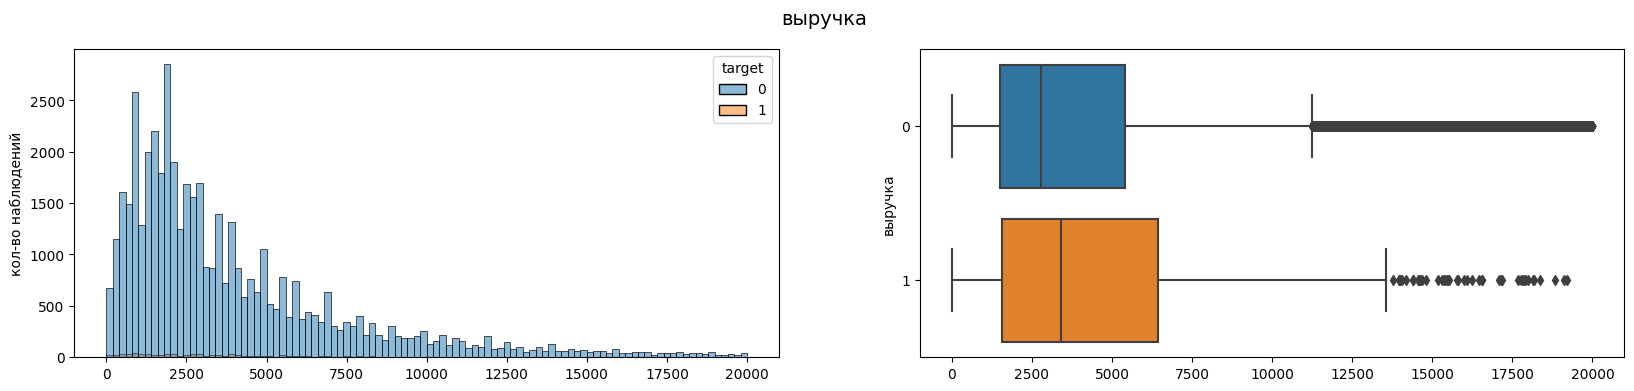

In [71]:
initial_data_analisys_numeric(df_target[df_target['revenue'] < 20_000], 'revenue', split_column = 'target', selected_bins = 100)

**`avg_price` - средняя цена товара**

Исходные данные содержали информацию о цене тавара. Включим ее в агрегированные данные как отношение суммарной выручке к суммарному количеству единиц товара.

In [72]:
df_target['avg_price'] = df_target['revenue'] / df_target['quantity']

средняя цена товара() - описательные статистики



count    49849.000000
mean      1483.308776
std       1388.245491
min          1.000000
25%        699.000000
50%       1249.000000
75%       1999.000000
max      53499.000000
Name: avg_price, dtype: float64

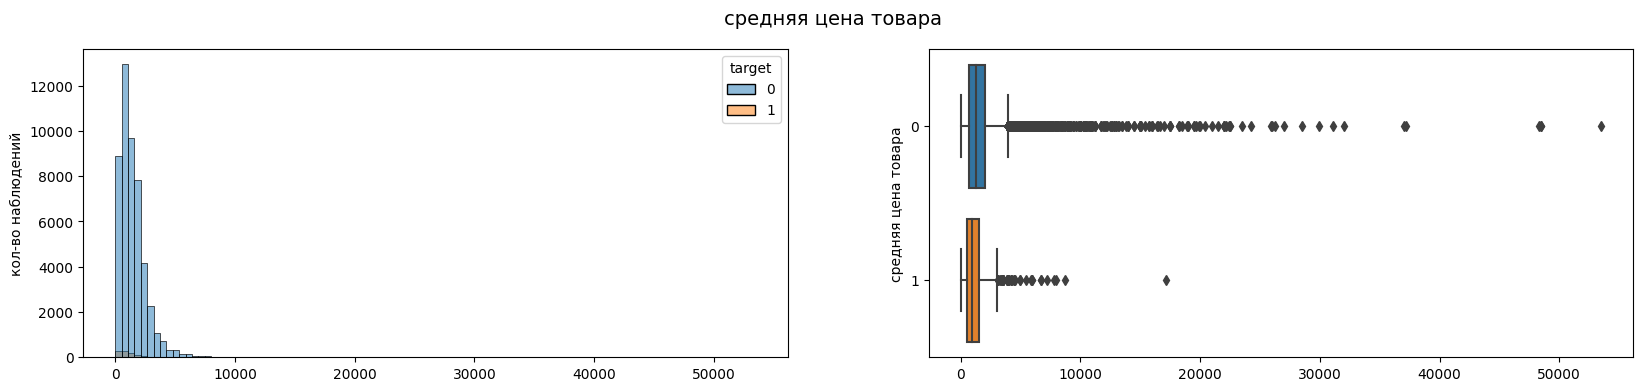

In [73]:
initial_data_analisys_numeric(df_target, 'avg_price', split_column = 'target', selected_bins = 100)

средняя цена товара() - описательные статистики



count    49157.000000
mean      1388.021335
std        943.472622
min          1.000000
25%        680.448276
50%       1220.692308
75%       1959.000000
max       4999.000000
Name: avg_price, dtype: float64

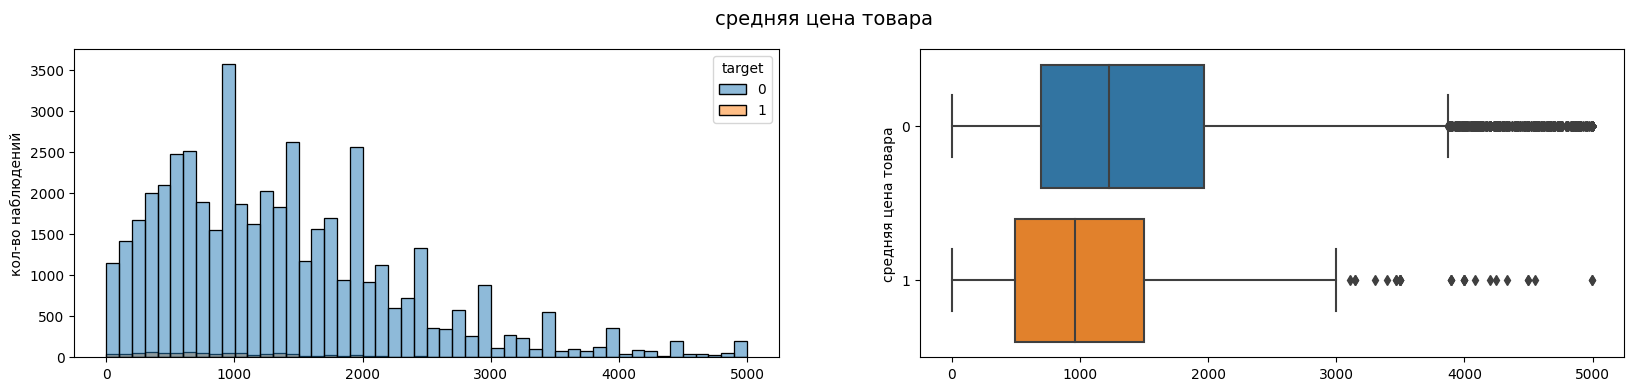

In [74]:
initial_data_analisys_numeric(df_target[df_target['avg_price'] < 5_000], 'avg_price', split_column = 'target', selected_bins = 50)

**`fav_cat` - любимая категория**

Для каждого покупателя определим любимую категорию товаров.

**Уровень 4 кодов**

Найдем для каждого покупателя по каждой категории товаров сумму по общему количеству единиц товара и суммарной выручке.

In [75]:
df_purchases_agg = df_purchases.groupby(['client_id', 'category_ids_upd']).agg({
    'quantity' : 'sum',
    'revenue' : 'sum'
}).reset_index()

In [76]:
df_purchases_agg.head()

,client_id,category_ids_upd,quantity,revenue
0,1515915625468060902,"['4', '27', '176', '458']",2,398.0
1,1515915625468060902,"['4', '27', '1828', '1599']",1,1299.0
2,1515915625468060902,"['4', '28', '244', '432']",1,999.0
3,1515915625468060902,"['4', '28', '260', '420']",2,3998.0
4,1515915625468060902,"['4', '28', '290', '422']",1,299.0


Для каждого покупателя найдем максимальное количество единиц товара и максимальную сумму выручки, чтобы определить любимую категорию.

In [77]:
df_purchases_max = df_purchases_agg.groupby('client_id').agg({
    'quantity' : 'max',
    'revenue' : 'max'
}).reset_index()

In [78]:
df_purchases_max.head()

,client_id,quantity,revenue
0,1515915625468060902,2,3998.0
1,1515915625468061003,7,16235.0
2,1515915625468061099,1,299.0
3,1515915625468061100,2,2098.0
4,1515915625468061170,12,25192.0


Определим любимую категорию как категорию с максимальной выручкой.

In [79]:
df_purchases_max.rename(columns={'revenue':'max'}, inplace=True)
df_purchases_max.drop('quantity', axis =1, inplace = True)
df_purchases_max.head()

,client_id,max
0,1515915625468060902,3998.0
1,1515915625468061003,16235.0
2,1515915625468061099,299.0
3,1515915625468061100,2098.0
4,1515915625468061170,25192.0


Для каждого клиента отфильтруем категорию, выручка по которой совпадает с максиальной выручкой.

In [80]:
df_purchases_agg = df_purchases_agg.merge(df_purchases_max, on = 'client_id')
df_purchases_agg.head()

,client_id,category_ids_upd,quantity,revenue,max
0,1515915625468060902,"['4', '27', '176', '458']",2,398.0,3998.0
1,1515915625468060902,"['4', '27', '1828', '1599']",1,1299.0,3998.0
2,1515915625468060902,"['4', '28', '244', '432']",1,999.0,3998.0
3,1515915625468060902,"['4', '28', '260', '420']",2,3998.0,3998.0
4,1515915625468060902,"['4', '28', '290', '422']",1,299.0,3998.0


In [81]:
df_purchases_agg['check'] = df_purchases_agg['revenue'] == df_purchases_agg['max']

In [82]:
df_purchases_agg = df_purchases_agg.query('check == True')
df_purchases_agg.head(3)

,client_id,category_ids_upd,quantity,revenue,max,check
3,1515915625468060902,"['4', '28', '260', '420']",2,3998.0,3998.0,True
5,1515915625468061003,"['4', '28', '249', '615']",7,16235.0,16235.0,True
6,1515915625468061099,"['4', '28', '290', '424']",1,299.0,299.0,True


In [83]:
df_purchases_agg.groupby('client_id')['check'].agg('sum').max()

6

Обратим внимание, что для некоторых покупателей максимальная выручка может приходиться на несколько разных категорий (максимум на 6 категорий). Найдем количество таких покупателей. 

In [84]:
mult_max = df_purchases_agg.groupby('client_id')['check'].agg('sum').reset_index().query('check > 1')['client_id'].tolist()
len(mult_max)

971

In [85]:
df_purchases_agg.query('client_id in @mult_max').head(3)

,client_id,category_ids_upd,quantity,revenue,max,check
72,1515915625468064112,"['2', '18', '267', '443']",1,399.0,399.0,True
73,1515915625468064112,"['4', '28', '146', '1587']",1,399.0,399.0,True
74,1515915625468064112,"['5562', '5630', '5592', '676']",1,399.0,399.0,True


In [86]:
len(mult_max) / len(df_purchases_agg['client_id'].unique())

0.01947882605468515

Т.к. количество покупателей с несколькими одинаково любимыми категориями не велико относительно общего количества покупателей в исследовании (около 2%), оставим одну любимую категорию случайным образом.

In [87]:
df_purchases_agg = df_purchases_agg.drop_duplicates(subset = ['client_id', 'check'])
df_purchases_agg.groupby('client_id')['check'].agg('sum').max()

1

In [88]:
df_purchases_agg.head(3)

,client_id,category_ids_upd,quantity,revenue,max,check
3,1515915625468060902,"['4', '28', '260', '420']",2,3998.0,3998.0,True
5,1515915625468061003,"['4', '28', '249', '615']",7,16235.0,16235.0,True
6,1515915625468061099,"['4', '28', '290', '424']",1,299.0,299.0,True


In [89]:
df_purchases_agg = df_purchases_agg.drop(['quantity', 'revenue', 'max', 'check'], axis =1)

In [90]:
df_purchases_agg.rename(columns={'category_ids_upd':'fav_cat_4'}, inplace=True)

In [91]:
df_purchases_agg.head(3)

,client_id,fav_cat_4
3,1515915625468060902,"['4', '28', '260', '420']"
5,1515915625468061003,"['4', '28', '249', '615']"
6,1515915625468061099,"['4', '28', '290', '424']"


Соединим новый признак с таргетом.

In [92]:
df_target = df_target.merge(df_purchases_agg, on = 'client_id', how = 'left')
df_target.head()

,client_id,target,quantity,purchases_count,revenue,mult_purchases,avg_price,fav_cat_4
0,1515915625468060902,0,7,1,6993.0,0,999.000000,"['4', '28', '260', '420']"
1,1515915625468061003,1,7,1,16235.0,0,2319.285714,"['4', '28', '249', '615']"
2,1515915625468061099,0,1,1,299.0,0,299.000000,"['4', '28', '290', '424']"
3,1515915625468061100,0,2,1,2098.0,0,1049.000000,"['4', '27', '1828', '5717']"
4,1515915625468061170,0,19,3,33601.0,1,1768.473684,"['4', '28', '260', '420']"


**Уровень 2 кодов**

Аналогичным образом определим для каждого покупателя любимую категорию товаров на уровне 2-числовой кодировки.

In [93]:
df_purchases_agg = df_purchases.groupby(['client_id', 'category_ids_2_num']).agg({
    'quantity' : 'sum',
    'revenue' : 'sum'
}).reset_index()
df_purchases_agg.head()

,client_id,category_ids_2_num,quantity,revenue
0,1515915625468060902,"['4', '27']",3,1697.0
1,1515915625468060902,"['4', '28']",4,5296.0
2,1515915625468061003,"['4', '28']",7,16235.0
3,1515915625468061099,"['4', '28']",1,299.0
4,1515915625468061100,"['4', '27']",2,2098.0


In [94]:
df_purchases_max = df_purchases_agg.groupby('client_id').agg({
    'quantity' : 'max',
    'revenue' : 'max'
}).reset_index()
df_purchases_max.rename(columns={'revenue':'max'}, inplace=True)
df_purchases_max.drop('quantity', axis =1, inplace = True)
df_purchases_max.head()

,client_id,max
0,1515915625468060902,5296.0
1,1515915625468061003,16235.0
2,1515915625468061099,299.0
3,1515915625468061100,2098.0
4,1515915625468061170,28189.0


In [95]:
df_purchases_agg = df_purchases_agg.merge(df_purchases_max, on = 'client_id')
df_purchases_agg['check'] = df_purchases_agg['revenue'] == df_purchases_agg['max']
df_purchases_agg = df_purchases_agg.query('check == True')
df_purchases_agg.head()

,client_id,category_ids_2_num,quantity,revenue,max,check
1,1515915625468060902,"['4', '28']",4,5296.0,5296.0,True
2,1515915625468061003,"['4', '28']",7,16235.0,16235.0,True
3,1515915625468061099,"['4', '28']",1,299.0,299.0,True
4,1515915625468061100,"['4', '27']",2,2098.0,2098.0,True
6,1515915625468061170,"['4', '28']",15,28189.0,28189.0,True


In [96]:
df_purchases_agg.groupby('client_id')['check'].agg('sum').max()

5

In [97]:
mult_max = df_purchases_agg.groupby('client_id')['check'].agg('sum').reset_index().query('check > 1')['client_id'].tolist()
len(mult_max)

195

In [98]:
df_purchases_agg.query('client_id in @mult_max').head(3)

,client_id,category_ids_2_num,quantity,revenue,max,check
53,1515915625468064112,"['2', '18']",1,399.0,399.0,True
54,1515915625468064112,"['4', '28']",1,399.0,399.0,True
55,1515915625468064112,"['5562', '5630']",1,399.0,399.0,True


In [99]:
df_purchases_agg = df_purchases_agg.drop_duplicates(subset = ['client_id', 'check'])
df_purchases_agg.groupby('client_id')['check'].agg('sum').max()

1

In [100]:
df_purchases_agg = df_purchases_agg.drop(['quantity', 'revenue', 'max', 'check'], axis =1)
df_purchases_agg.rename(columns={'category_ids_2_num':'fav_cat_2'}, inplace=True)
df_purchases_agg.head(3)

,client_id,fav_cat_2
1,1515915625468060902,"['4', '28']"
2,1515915625468061003,"['4', '28']"
3,1515915625468061099,"['4', '28']"


Соединим новый признак с таргетом и проведем исследовательский анализ.

In [101]:
df_target = df_target.merge(df_purchases_agg, on = 'client_id', how = 'left')
df_target.head()

,client_id,target,quantity,purchases_count,revenue,mult_purchases,avg_price,fav_cat_4,fav_cat_2
0,1515915625468060902,0,7,1,6993.0,0,999.000000,"['4', '28', '260', '420']","['4', '28']"
1,1515915625468061003,1,7,1,16235.0,0,2319.285714,"['4', '28', '249', '615']","['4', '28']"
2,1515915625468061099,0,1,1,299.0,0,299.000000,"['4', '28', '290', '424']","['4', '28']"
3,1515915625468061100,0,2,1,2098.0,0,1049.000000,"['4', '27', '1828', '5717']","['4', '27']"
4,1515915625468061170,0,19,3,33601.0,1,1768.473684,"['4', '28', '260', '420']","['4', '28']"


любимая категория - количество значений



fav_cat_2
['4', '28']         24609
['2', '18']          7712
['5562', '5630']     2532
['4', '31']          2460
['5562', '5631']     2161
['4', '27']          1828
['5562', '5589']     1397
['4', '29']          1353
['5562', '5633']      895
['6060', '6058']      776
['5562', '5634']      673
['2', '17']           587
['5562', '5536']      561
['5562', '5683']      433
['4', '1822']         400
['5963', '5959']      373
['5562', '5632']      275
['6060', '6057']      167
['5562', '5597']      152
['4', '5837']         148
['5562', '5599']      125
['5562', '5558']      121
['6060', '6059']       66
['5562', '5697']       19
['None']               10
['4', '30']             8
['4', '44']             7
['1', '22']             1
Name: fav_cat_2, dtype: int64

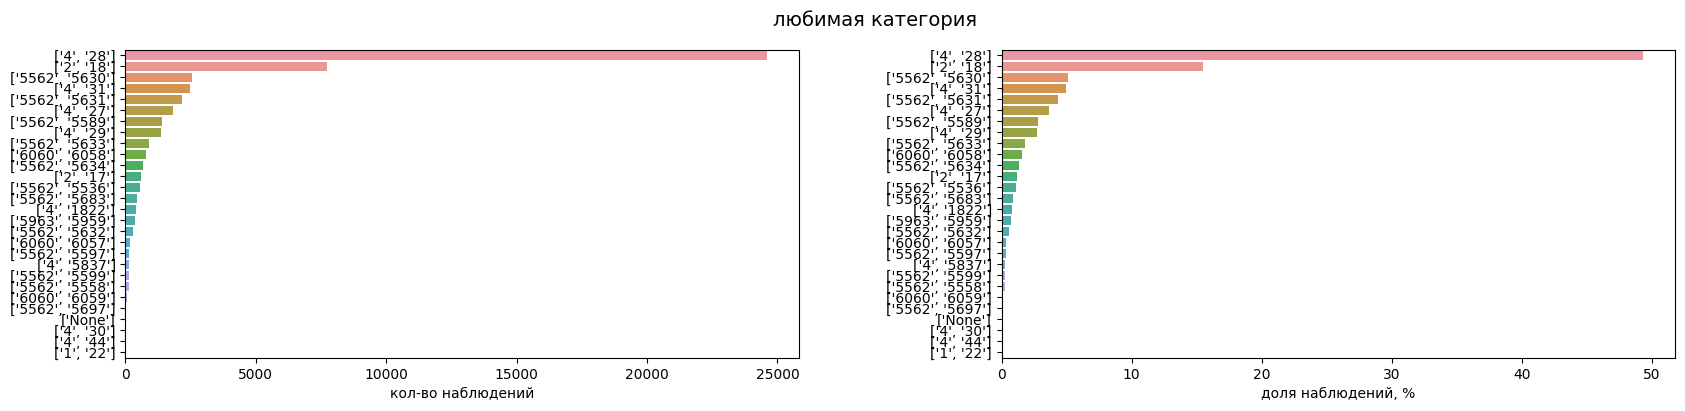

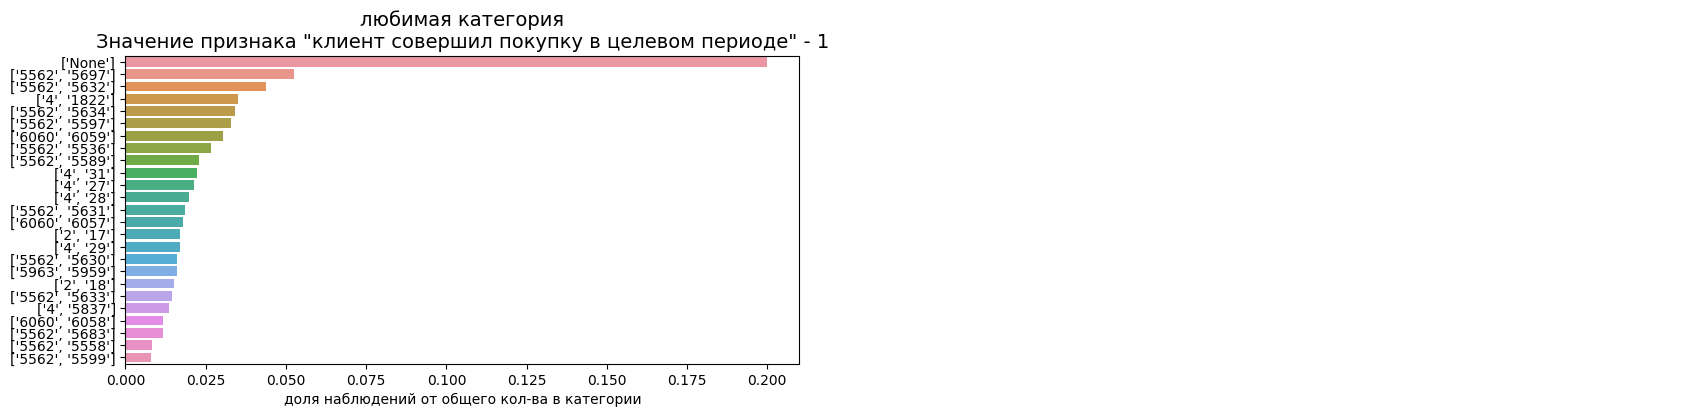

In [102]:
initial_data_analisys_category(df_target, 'fav_cat_2', target_column = 'target', target_value = 1)

**Время, прошедшее с последней покупки**

Для каждого покупателя определим наиболее позднюю дату покупки и найдем разность между этой датой и наиболее поздней датой, сохраненной в датафрейме. Таким образом найдем количество дней, прошедшее между наиболее поздней покупкой и датой выгрузки данных для исследования.

In [103]:
df_purchases_agg = df_purchases.groupby(['client_id'])['date'].agg('max').reset_index()
df_purchases_agg

,client_id,date
0,1515915625468060902,2022-05-27
1,1515915625468061003,2023-01-04
2,1515915625468061099,2022-05-17
3,1515915625468061100,2024-02-10
4,1515915625468061170,2023-06-17
...,...,...
49844,1515915626010261344,2024-02-16
49845,1515915626010266132,2024-02-14
49846,1515915626010439406,2024-02-16
49847,1515915626010443527,2024-02-16


In [104]:
max_date = datetime.strptime(df_purchases_agg['date'].max(), '%Y-%m-%d')
max_date

datetime.datetime(2024, 2, 16, 0, 0)

In [105]:
df_purchases_agg['days_from_latest_purchase'] = df_purchases_agg['date'].apply(lambda x: (max_date - datetime.strptime(x, '%Y-%m-%d')).days + 1)
df_purchases_agg.head()

,client_id,date,days_from_latest_purchase
0,1515915625468060902,2022-05-27,631
1,1515915625468061003,2023-01-04,409
2,1515915625468061099,2022-05-17,641
3,1515915625468061100,2024-02-10,7
4,1515915625468061170,2023-06-17,245


Соединим новый признак с таргетом и проведем исследовательский анализ.

In [106]:
df_target = df_target.merge(df_purchases_agg.drop('date', axis = 1), on = 'client_id', how = 'left')
df_target.head(3)

,client_id,target,quantity,purchases_count,revenue,mult_purchases,avg_price,fav_cat_4,fav_cat_2,days_from_latest_purchase
0,1515915625468060902,0,7,1,6993.0,0,999.000000,"['4', '28', '260', '420']","['4', '28']",631
1,1515915625468061003,1,7,1,16235.0,0,2319.285714,"['4', '28', '249', '615']","['4', '28']",409
2,1515915625468061099,0,1,1,299.0,0,299.000000,"['4', '28', '290', '424']","['4', '28']",641


дней с последней покупки() - описательные статистики



count    49849.000000
mean       362.931593
std        185.301691
min          1.000000
25%        234.000000
50%        349.000000
75%        543.000000
max        642.000000
Name: days_from_latest_purchase, dtype: float64

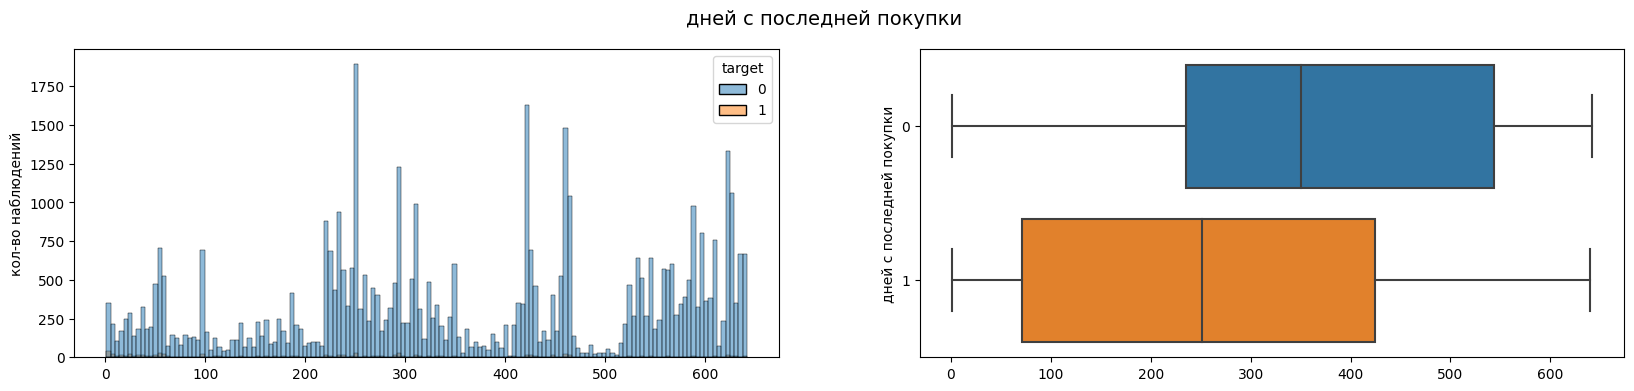

In [107]:
initial_data_analisys_numeric(df_target, 'days_from_latest_purchase', split_column = 'target', selected_bins = 150)

#### Характеристики маркетенговых коммуникаций

**Действия покупателей**

Для каждого покупателя определим суммароное количество совершенных действий каждого вида.

In [108]:
df_messages_agg = df_messages.pivot_table(index = 'client_id', columns = 'event', values = 'message_id', aggfunc = 'count').reset_index()
df_messages_agg.head()

event,client_id,click,close,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe
0,1515915625468060902,10.0,NaN,NaN,NaN,NaN,35.0,5.0,126.0,NaN,NaN,1.0
1,1515915625468061003,5.0,NaN,NaN,NaN,NaN,5.0,1.0,154.0,NaN,NaN,NaN
2,1515915625468061099,8.0,NaN,NaN,2.0,NaN,51.0,NaN,215.0,NaN,NaN,NaN
3,1515915625468061100,1.0,NaN,NaN,1.0,NaN,157.0,1.0,267.0,1.0,NaN,NaN
4,1515915625468061170,16.0,NaN,NaN,NaN,NaN,31.0,3.0,243.0,NaN,NaN,NaN


In [109]:
df_messages_agg = df_messages_agg.fillna(0)
df_messages_agg.head()

event,client_id,click,close,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe
0,1515915625468060902,10.0,0.0,0.0,0.0,0.0,35.0,5.0,126.0,0.0,0.0,1.0
1,1515915625468061003,5.0,0.0,0.0,0.0,0.0,5.0,1.0,154.0,0.0,0.0,0.0
2,1515915625468061099,8.0,0.0,0.0,2.0,0.0,51.0,0.0,215.0,0.0,0.0,0.0
3,1515915625468061100,1.0,0.0,0.0,1.0,0.0,157.0,1.0,267.0,1.0,0.0,0.0
4,1515915625468061170,16.0,0.0,0.0,0.0,0.0,31.0,3.0,243.0,0.0,0.0,0.0


Исследуем редкие действия, чтобы понять как часто они могут совершаться отдельно взятым покупателем.

In [110]:
df_messages_agg.sort_values(by = 'close', ascending = False).head(3)

event,client_id,click,close,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe
36977,1515915625593610304,20.0,1.0,0.0,3.0,0.0,256.0,0.0,293.0,1.0,0.0,0.0
35621,1515915625585010520,0.0,0.0,0.0,0.0,0.0,16.0,0.0,21.0,0.0,0.0,0.0
35545,1515915625584454592,7.0,0.0,0.0,0.0,0.0,0.0,0.0,123.0,0.0,0.0,0.0


In [111]:
df_messages_agg.sort_values(by = 'complain', ascending = False).head(3)

event,client_id,click,close,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe
2473,1515915625468233821,2.0,0.0,80.0,0.0,0.0,4.0,1.0,72.0,0.0,0.0,0.0
732,1515915625468111378,2.0,0.0,47.0,0.0,0.0,75.0,2.0,195.0,0.0,0.0,1.0
7444,1515915625487605189,2.0,0.0,27.0,0.0,0.0,7.0,2.0,248.0,0.0,0.0,0.0


In [112]:
df_messages_agg.sort_values(by = 'hard_bounce', ascending = False).head(3)

event,client_id,click,close,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe
37859,1515915625615134152,21.0,0.0,0.0,36.0,0.0,324.0,3.0,276.0,0.0,0.0,0.0
39193,1515915625634092896,12.0,0.0,0.0,31.0,0.0,34.0,23.0,72.0,1.0,0.0,0.0
32240,1515915625566028598,0.0,0.0,0.0,30.0,0.0,2.0,0.0,62.0,0.0,0.0,0.0


In [113]:
df_messages_agg.sort_values(by = 'hbq_spam', ascending = False).head(3)

event,client_id,click,close,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe
8689,1515915625488186422,5.0,0.0,0.0,0.0,2.0,11.0,1.0,232.0,0.0,0.0,0.0
6952,1515915625487385669,11.0,0.0,0.0,0.0,2.0,241.0,2.0,349.0,0.0,0.0,0.0
10843,1515915625488964571,7.0,0.0,0.0,0.0,2.0,11.0,1.0,415.0,0.0,0.0,0.0


In [114]:
df_messages_agg.sort_values(by = 'soft_bounce', ascending = False).head(3)

event,client_id,click,close,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe
14599,1515915625489942506,0.0,0.0,0.0,1.0,0.0,171.0,0.0,448.0,141.0,0.0,0.0
33002,1515915625566815618,0.0,0.0,0.0,1.0,0.0,94.0,0.0,348.0,133.0,0.0,0.0
24771,1515915625506930752,1.0,0.0,0.0,1.0,0.0,46.0,1.0,376.0,129.0,0.0,0.0


In [115]:
df_messages_agg.sort_values(by = 'subscribe', ascending = False).head(3)

event,client_id,click,close,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe
33202,1515915625566864504,18.0,0.0,0.0,1.0,0.0,315.0,4.0,231.0,0.0,3.0,6.0
32712,1515915625566726665,2.0,0.0,0.0,1.0,0.0,40.0,0.0,90.0,0.0,3.0,6.0
36059,1515915625588077337,5.0,0.0,0.0,0.0,0.0,95.0,1.0,112.0,0.0,2.0,6.0


In [116]:
df_messages_agg.sort_values(by = 'unsubscribe', ascending = False).head(3)

event,client_id,click,close,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe
35841,1515915625586686715,1.0,0.0,0.0,0.0,0.0,10.0,1.0,115.0,0.0,0.0,8.0
32993,1515915625566814834,2.0,0.0,0.0,0.0,0.0,4.0,5.0,65.0,0.0,1.0,8.0
16423,1515915625490462803,11.0,0.0,0.0,0.0,0.0,26.0,1.0,78.0,0.0,0.0,8.0


Негативные действия являются крайне редкими, и не ведут к покупкам, поэтому будем использовать следующий подход к созданию новых признаков:
* Для положительных действий рассчитаем показатели конверсии:
    * отношение открытых сообщений к отправленным
    * отношение кликов к открытым сообщениям
    * отношение покупок к кликам
* Для негативных действием создадим бинарные признаки:
    * было ли совершено негативное действие определенного вида хотя бы 1 раз (`0` - нет,  `1` - да)
    * было ли совершено хотя бы одно из негативных действий хотя бы 1 раз (`0` - нет,  `1` - да)

In [117]:
df_messages_agg['open_to_send'] = df_messages_agg['open'] / df_messages_agg['send']
df_messages_agg['click_to_open'] = df_messages_agg['click'] / df_messages_agg['open']
df_messages_agg['purchase_to_click'] = df_messages_agg['purchase'] / df_messages_agg['click']
df_messages_agg.head()

event,client_id,click,close,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe,open_to_send,click_to_open,purchase_to_click
0,1515915625468060902,10.0,0.0,0.0,0.0,0.0,35.0,5.0,126.0,0.0,0.0,1.0,0.277778,0.285714,0.5000
1,1515915625468061003,5.0,0.0,0.0,0.0,0.0,5.0,1.0,154.0,0.0,0.0,0.0,0.032468,1.000000,0.2000
2,1515915625468061099,8.0,0.0,0.0,2.0,0.0,51.0,0.0,215.0,0.0,0.0,0.0,0.237209,0.156863,0.0000
3,1515915625468061100,1.0,0.0,0.0,1.0,0.0,157.0,1.0,267.0,1.0,0.0,0.0,0.588015,0.006369,1.0000
4,1515915625468061170,16.0,0.0,0.0,0.0,0.0,31.0,3.0,243.0,0.0,0.0,0.0,0.127572,0.516129,0.1875


In [118]:
df_messages_agg['close'] = df_messages_agg['complain'].apply(lambda x: 1 if x>0 else 0)
df_messages_agg['complain'] = df_messages_agg['complain'].apply(lambda x: 1 if x>0 else 0)
df_messages_agg['hard_bounce'] = df_messages_agg['hard_bounce'].apply(lambda x: 1 if x>0 else 0)
df_messages_agg['hbq_spam'] = df_messages_agg['hbq_spam'].apply(lambda x: 1 if x>0 else 0)
df_messages_agg['soft_bounce'] = df_messages_agg['soft_bounce'].apply(lambda x: 1 if x>0 else 0)
df_messages_agg['subscribe'] = df_messages_agg['subscribe'].apply(lambda x: 1 if x>0 else 0)
df_messages_agg['unsubscribe'] = df_messages_agg['unsubscribe'].apply(lambda x: 1 if x>0 else 0)
df_messages_agg['negative_event'] = (df_messages_agg['close'] + df_messages_agg['complain'] + \
                                    df_messages_agg['hard_bounce'] + df_messages_agg['hbq_spam'] + df_messages_agg['soft_bounce'] + \
                                    df_messages_agg['unsubscribe']) > 1
df_messages_agg['negative_event'] = df_messages_agg['negative_event'].apply(lambda x: 1 if x else 0)

In [119]:
df_messages_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53329 entries, 0 to 53328
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   client_id          53329 non-null  int64  
 1   click              53329 non-null  float64
 2   close              53329 non-null  int64  
 3   complain           53329 non-null  int64  
 4   hard_bounce        53329 non-null  int64  
 5   hbq_spam           53329 non-null  int64  
 6   open               53329 non-null  float64
 7   purchase           53329 non-null  float64
 8   send               53329 non-null  float64
 9   soft_bounce        53329 non-null  int64  
 10  subscribe          53329 non-null  int64  
 11  unsubscribe        53329 non-null  int64  
 12  open_to_send       53325 non-null  float64
 13  click_to_open      52077 non-null  float64
 14  purchase_to_click  48075 non-null  float64
 15  negative_event     53329 non-null  int64  
dtypes: float64(7), int64(9

In [120]:
df_messages_agg.head(3)

event,client_id,click,close,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe,open_to_send,click_to_open,purchase_to_click,negative_event
0,1515915625468060902,10.0,0,0,0,0,35.0,5.0,126.0,0,0,1,0.277778,0.285714,0.5,0
1,1515915625468061003,5.0,0,0,0,0,5.0,1.0,154.0,0,0,0,0.032468,1.000000,0.2,0
2,1515915625468061099,8.0,0,0,1,0,51.0,0.0,215.0,0,0,0,0.237209,0.156863,0.0,0


Заменим на нули значения `nan` и `inf`, которые возникли при создании новых признаков в результате деления на ноль.

In [121]:
df_messages_agg = df_messages_agg.fillna(0)
df_messages_agg = df_messages_agg.replace([np.inf, -np.inf], 0)
df_messages_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53329 entries, 0 to 53328
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   client_id          53329 non-null  int64  
 1   click              53329 non-null  float64
 2   close              53329 non-null  int64  
 3   complain           53329 non-null  int64  
 4   hard_bounce        53329 non-null  int64  
 5   hbq_spam           53329 non-null  int64  
 6   open               53329 non-null  float64
 7   purchase           53329 non-null  float64
 8   send               53329 non-null  float64
 9   soft_bounce        53329 non-null  int64  
 10  subscribe          53329 non-null  int64  
 11  unsubscribe        53329 non-null  int64  
 12  open_to_send       53329 non-null  float64
 13  click_to_open      53329 non-null  float64
 14  purchase_to_click  53329 non-null  float64
 15  negative_event     53329 non-null  int64  
dtypes: float64(7), int64(9

Объединим созданные признаки с таргетом.

In [122]:
df_target = df_target.merge(df_messages_agg, on = 'client_id', how = 'left')
df_target.head()

,client_id,target,quantity,purchases_count,revenue,mult_purchases,avg_price,fav_cat_4,fav_cat_2,days_from_latest_purchase,...,open,purchase,send,soft_bounce,subscribe,unsubscribe,open_to_send,click_to_open,purchase_to_click,negative_event
0,1515915625468060902,0,7,1,6993.0,0,999.000000,"['4', '28', '260', '420']","['4', '28']",631,...,35.0,5.0,126.0,0.0,0.0,1.0,0.277778,0.285714,0.5000,0.0
1,1515915625468061003,1,7,1,16235.0,0,2319.285714,"['4', '28', '249', '615']","['4', '28']",409,...,5.0,1.0,154.0,0.0,0.0,0.0,0.032468,1.000000,0.2000,0.0
2,1515915625468061099,0,1,1,299.0,0,299.000000,"['4', '28', '290', '424']","['4', '28']",641,...,51.0,0.0,215.0,0.0,0.0,0.0,0.237209,0.156863,0.0000,0.0
3,1515915625468061100,0,2,1,2098.0,0,1049.000000,"['4', '27', '1828', '5717']","['4', '27']",7,...,157.0,1.0,267.0,1.0,0.0,0.0,0.588015,0.006369,1.0000,1.0
4,1515915625468061170,0,19,3,33601.0,1,1768.473684,"['4', '28', '260', '420']","['4', '28']",245,...,31.0,3.0,243.0,0.0,0.0,0.0,0.127572,0.516129,0.1875,0.0


In [123]:
df_target.replace([np.inf, -np.inf], 0, inplace=True)

Проведем исследовательский анализ новых признаков.

открытые сообщения к отправленным() - описательные статистики



count    41165.000000
mean         0.295048
std          0.298052
min          0.000000
25%          0.028571
50%          0.191781
75%          0.502347
max          1.000000
Name: open_to_send, dtype: float64

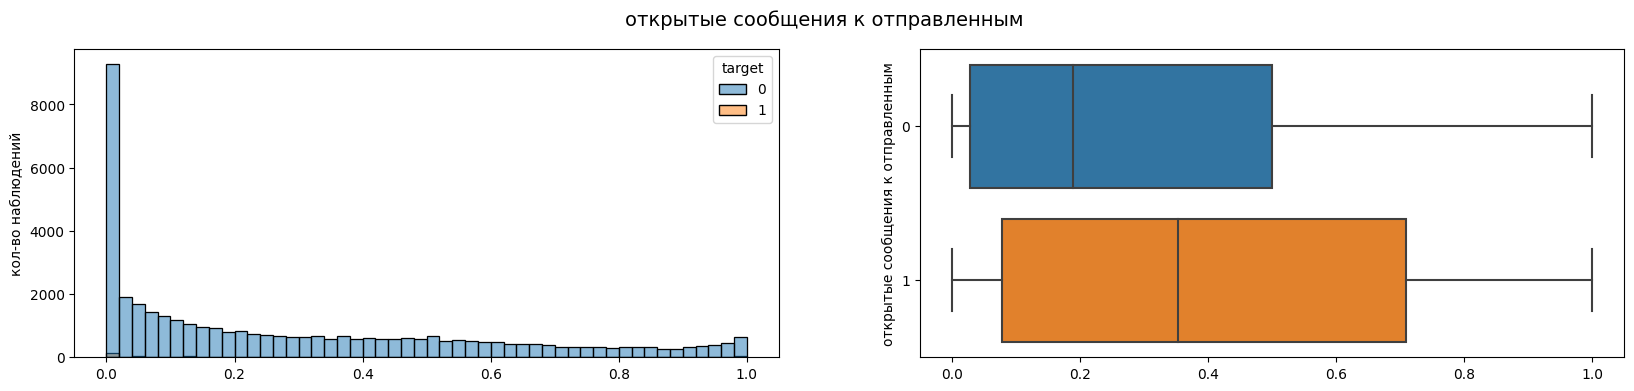

In [124]:
initial_data_analisys_numeric(df_target[df_target['open_to_send'] <= 1], 'open_to_send', split_column = 'target', selected_bins = 50)

клики к открытым сообщениям() - описательные статистики



count    38508.000000
mean         0.224539
std          0.275929
min          0.000000
25%          0.008850
50%          0.095548
75%          0.363636
max          1.000000
Name: click_to_open, dtype: float64

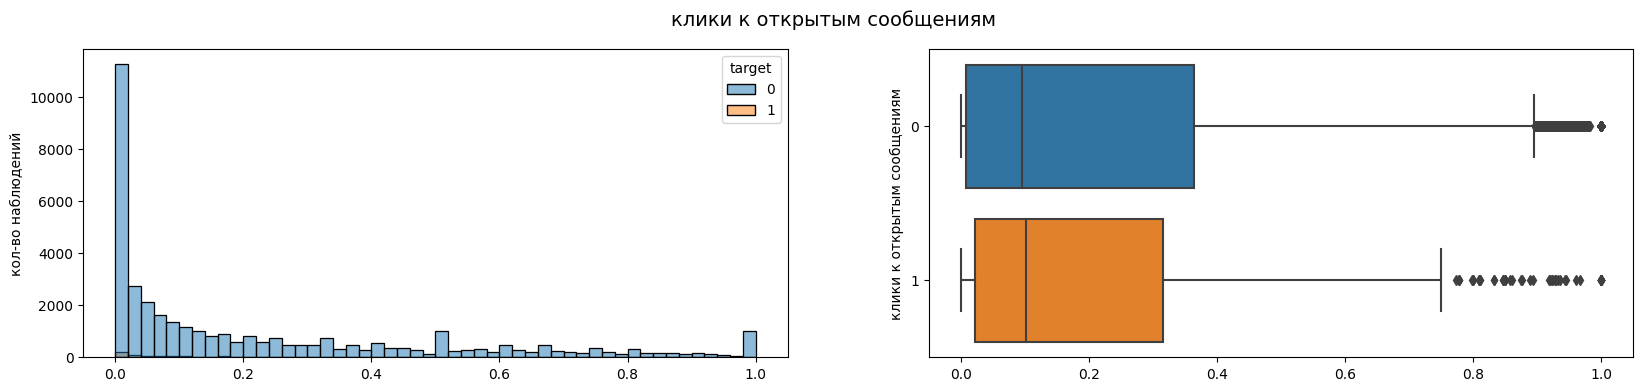

In [125]:
initial_data_analisys_numeric(df_target[df_target['click_to_open'] <= 1], 'click_to_open', split_column = 'target', selected_bins = 50)

покупки к кликам() - описательные статистики



count    41264.000000
mean         0.250792
std          0.276787
min          0.000000
25%          0.066667
50%          0.142857
75%          0.333333
max          1.000000
Name: purchase_to_click, dtype: float64

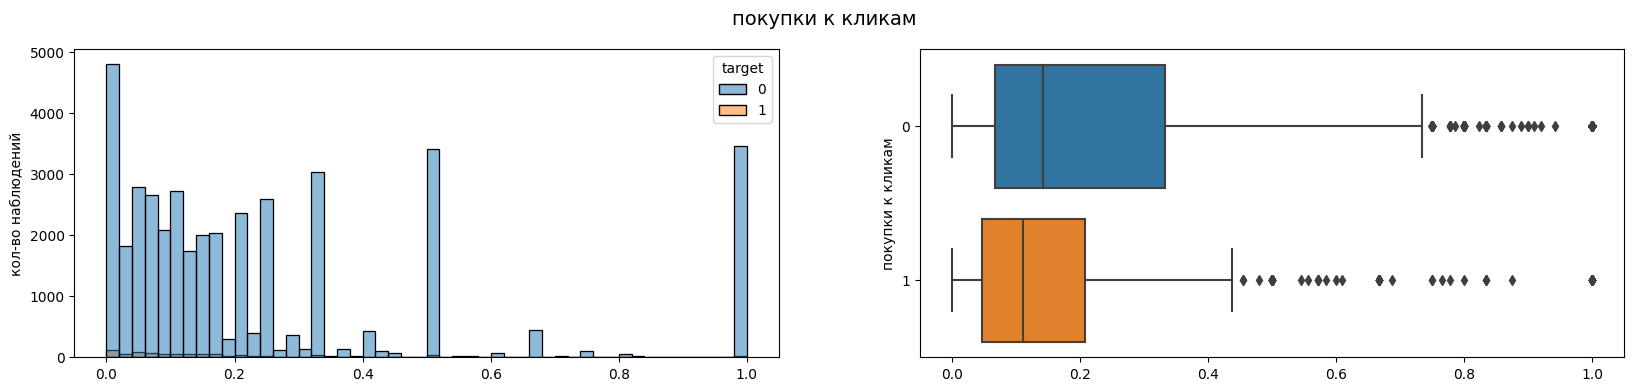

In [126]:
initial_data_analisys_numeric(df_target[df_target['purchase_to_click'] <= 1], 'purchase_to_click', split_column = 'target', selected_bins = 50)

были ли жалобы - количество значений



complain
0.0    41724
1.0      258
Name: complain, dtype: int64

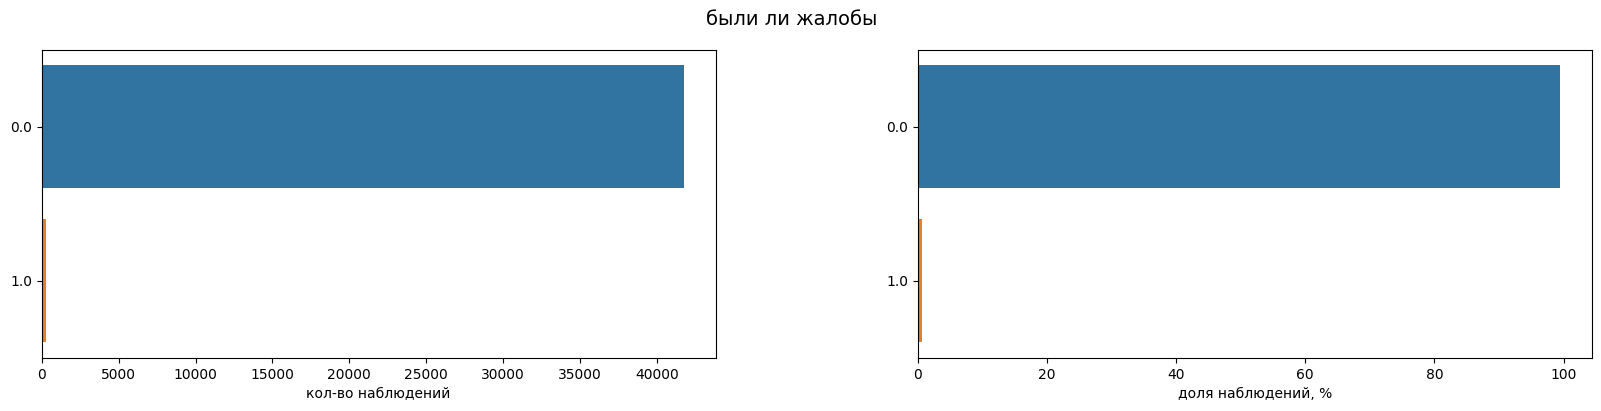

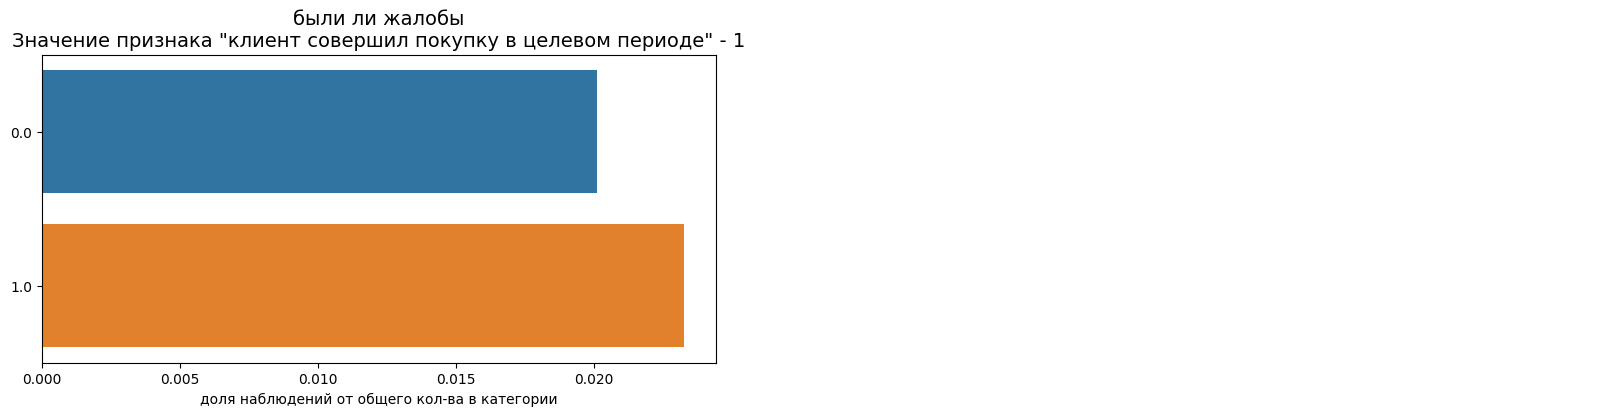

In [127]:
initial_data_analisys_category(df_target, 'complain', target_column = 'target', target_value = 1)

были ли возвраты (hard) - количество значений



hard_bounce
0.0    31348
1.0    10634
Name: hard_bounce, dtype: int64

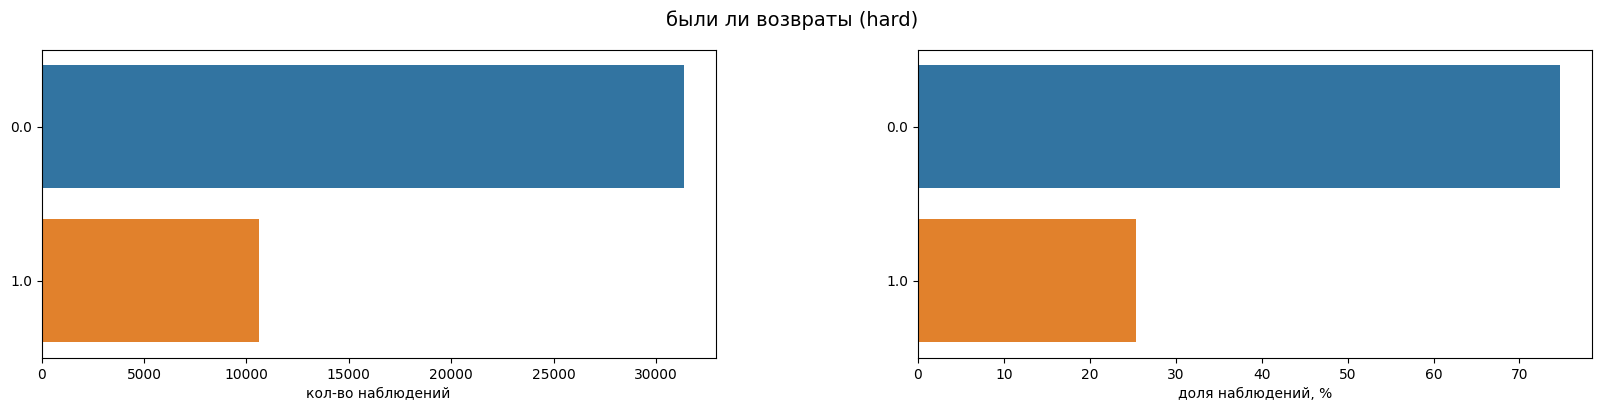

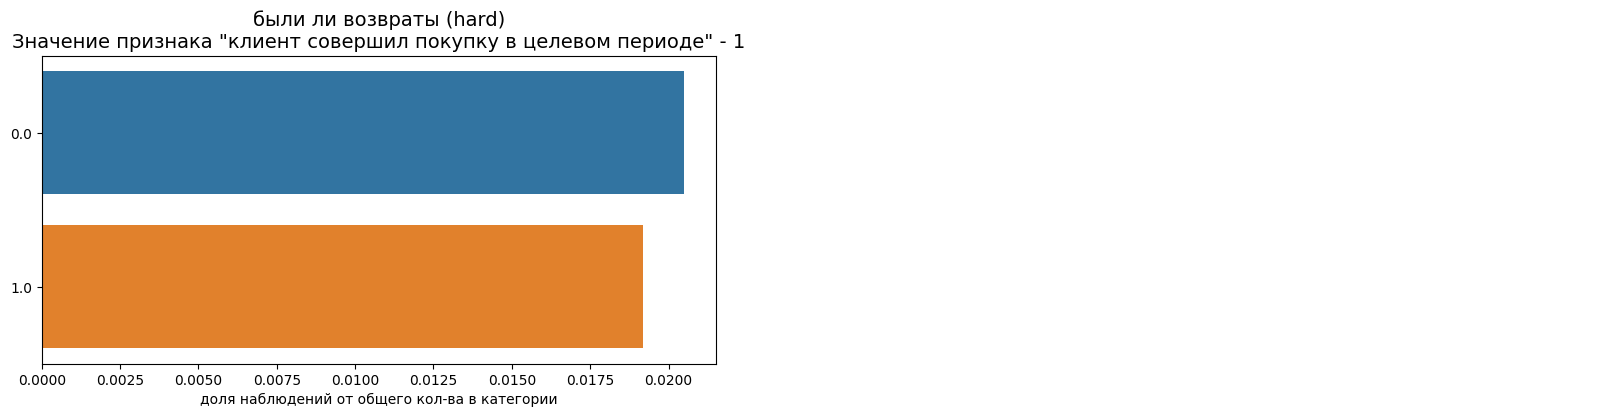

In [128]:
initial_data_analisys_category(df_target, 'hard_bounce', target_column = 'target', target_value = 1)

были ли возвраты (soft) - количество значений



soft_bounce
0.0    40400
1.0     1582
Name: soft_bounce, dtype: int64

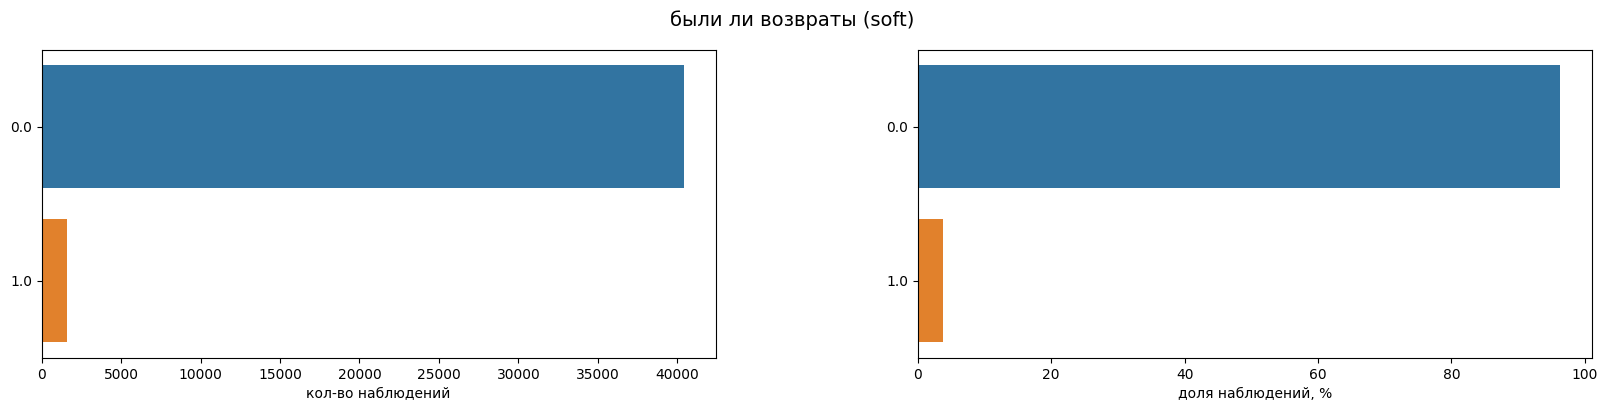

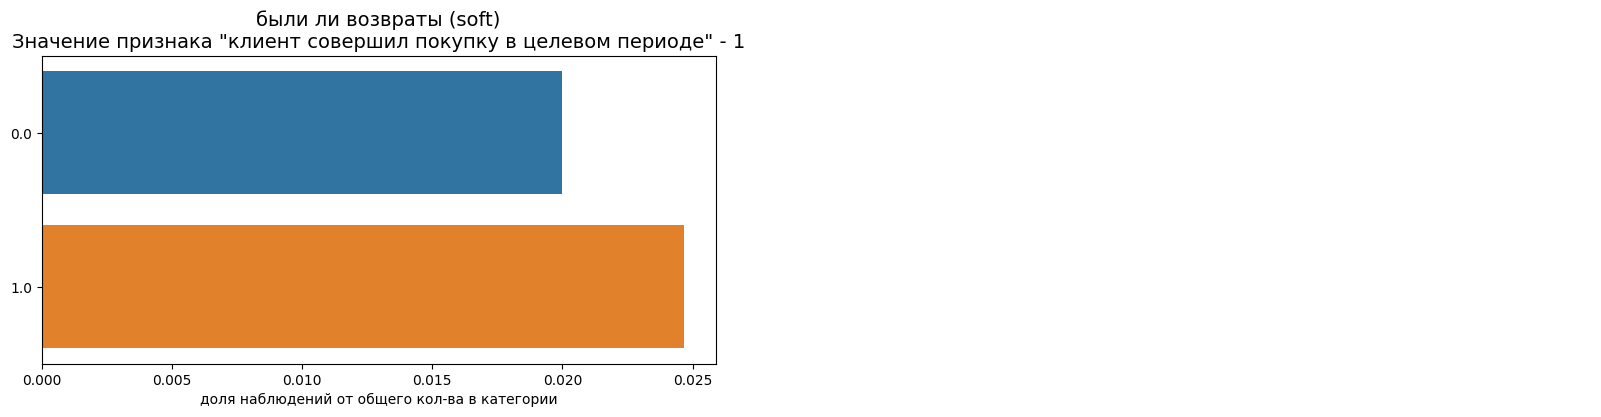

In [129]:
initial_data_analisys_category(df_target, 'soft_bounce', target_column = 'target', target_value = 1)

спам - количество значений



hbq_spam
0.0    41238
1.0      744
Name: hbq_spam, dtype: int64

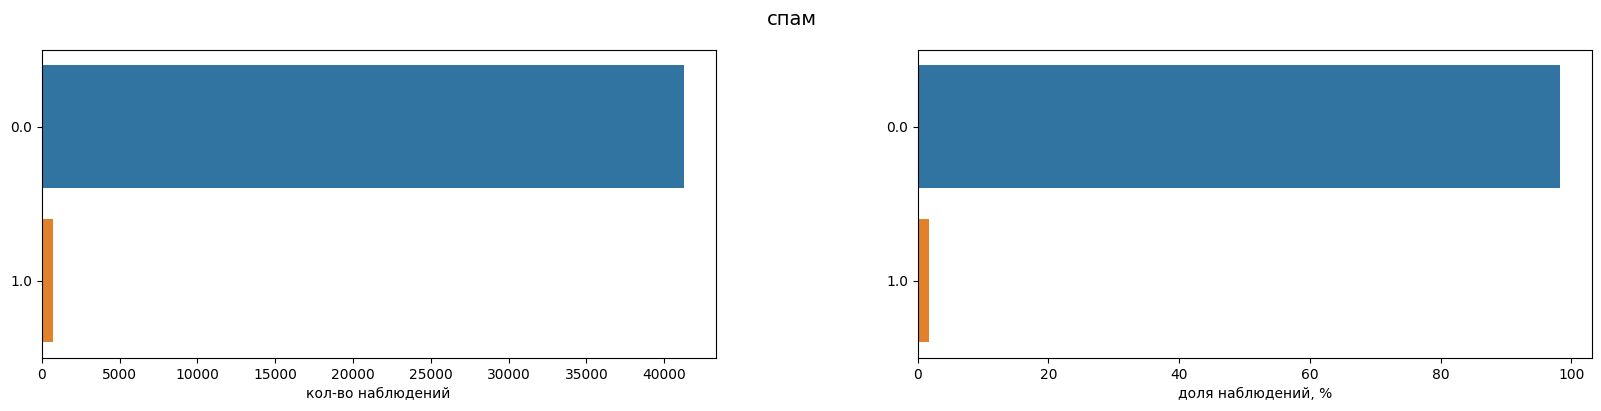

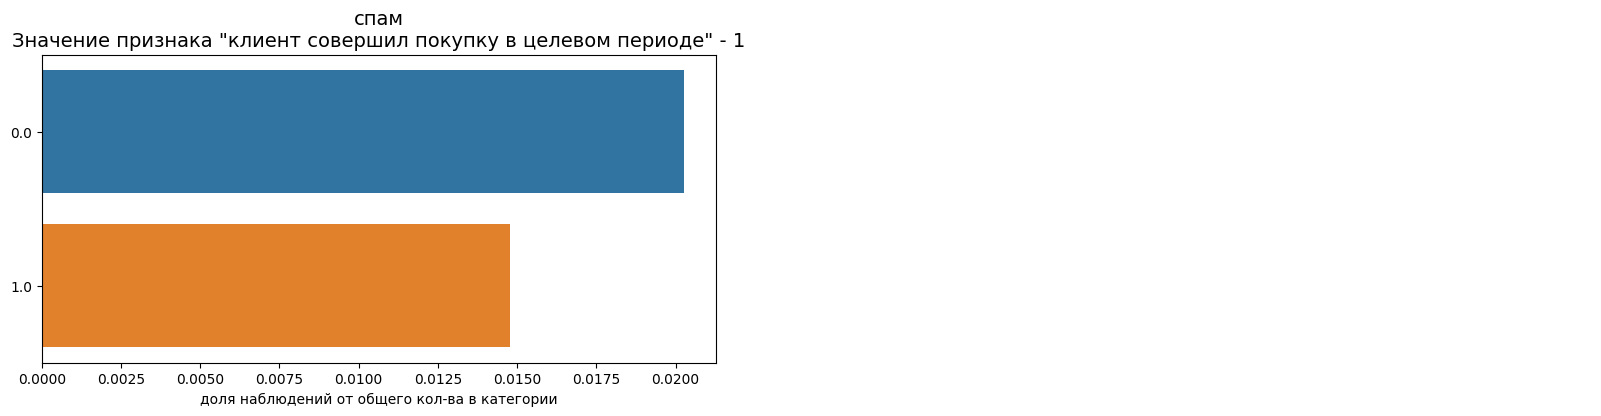

In [130]:
initial_data_analisys_category(df_target, 'hbq_spam', target_column = 'target', target_value = 1)

подписаться - количество значений



subscribe
0.0    41914
1.0       68
Name: subscribe, dtype: int64

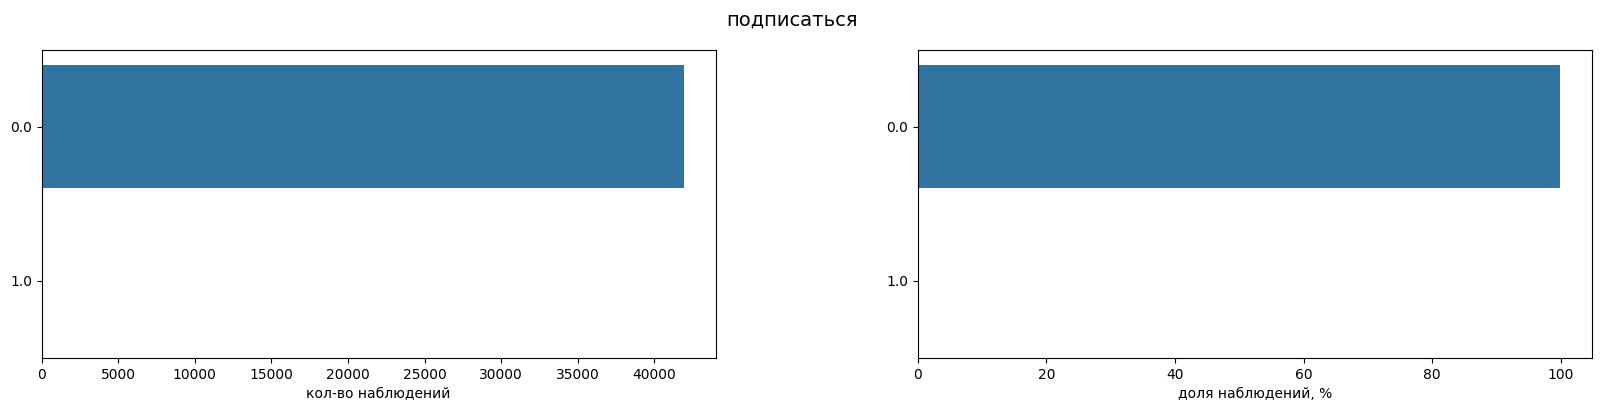

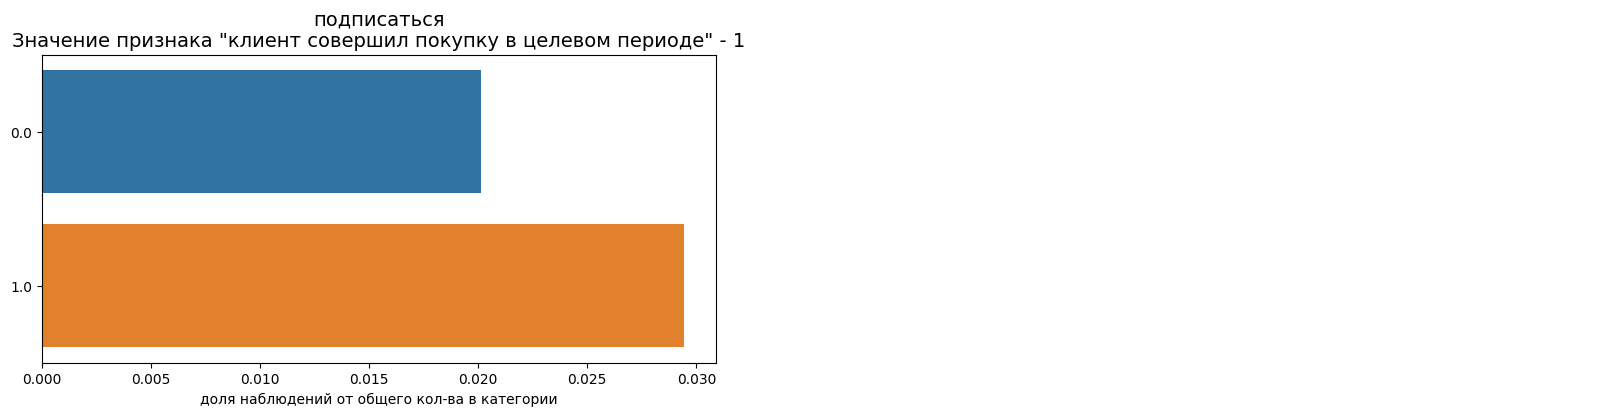

In [131]:
initial_data_analisys_category(df_target, 'subscribe', target_column = 'target', target_value = 1)

отписаться - количество значений



unsubscribe
0.0    39953
1.0     2029
Name: unsubscribe, dtype: int64

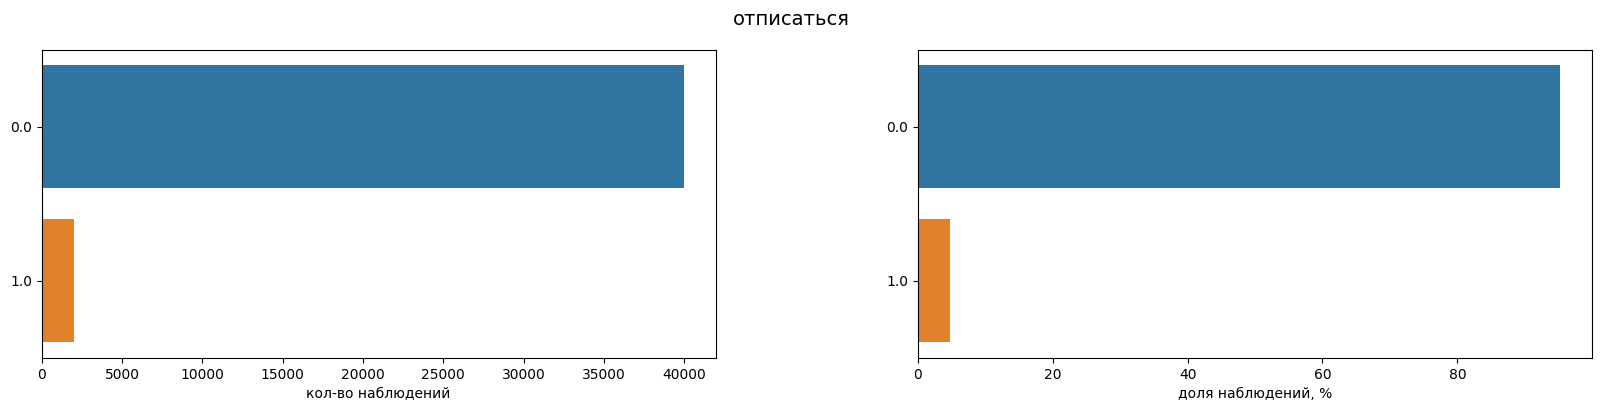

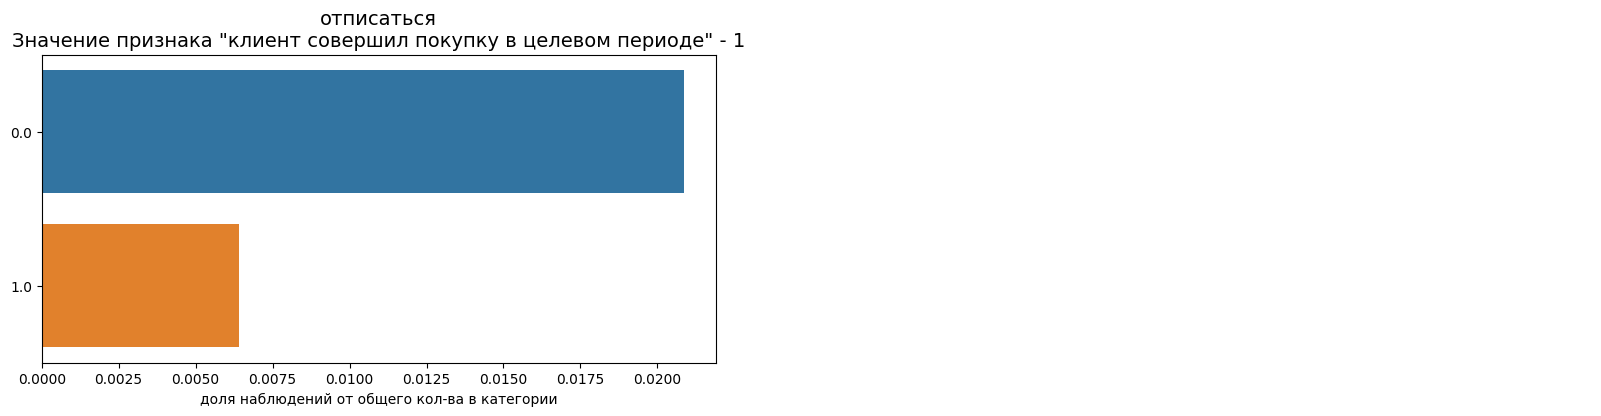

In [132]:
initial_data_analisys_category(df_target, 'unsubscribe', target_column = 'target', target_value = 1)

негативные действия - количество значений



negative_event
0.0    40417
1.0     1565
Name: negative_event, dtype: int64

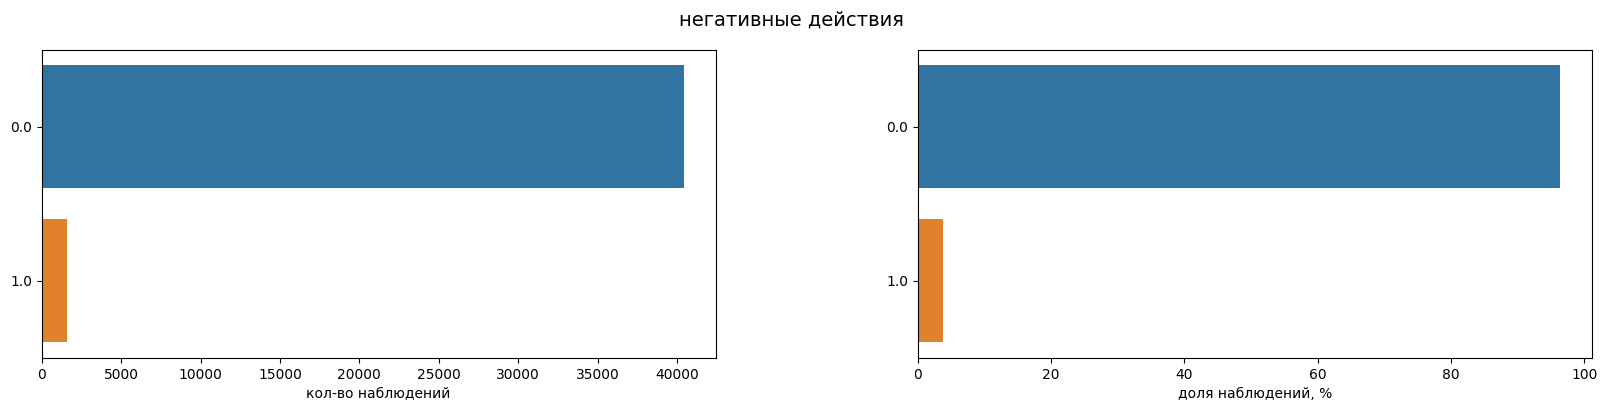

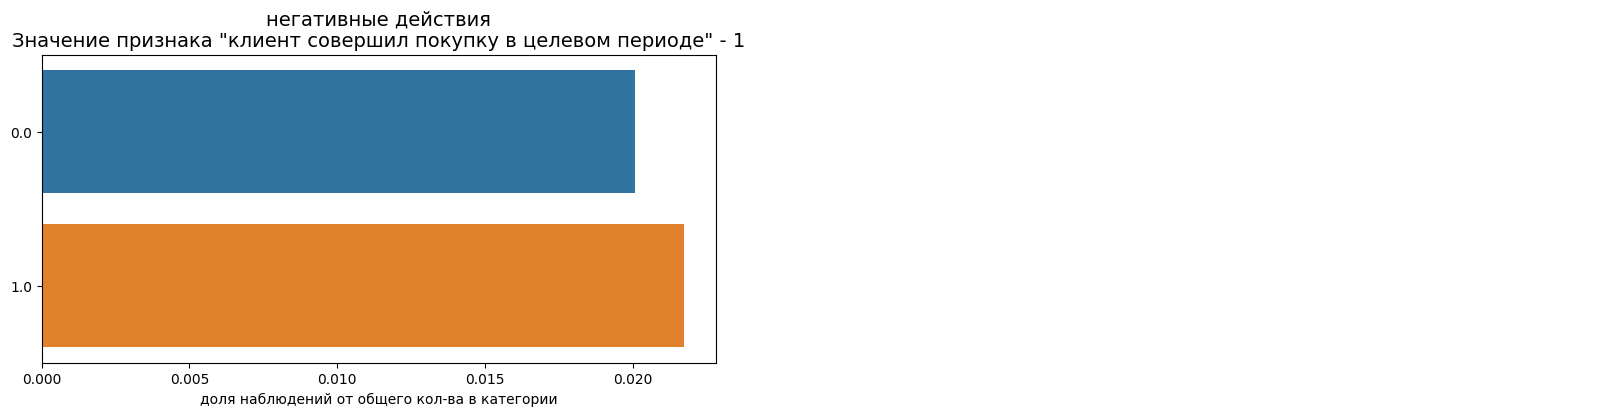

In [133]:
initial_data_analisys_category(df_target, 'negative_event', target_column = 'target', target_value = 1)

**Канал рассылки**

С учетом того, что в датафрейме дублируются `message_id`, когда с одним и тем же сообщением происходят разные действия, посчитаем уникальные значения `message_id` для каждого пользователя в разбивке по каналам коммуникации.

In [134]:
df_messages_agg = df_messages.groupby(['client_id', 'channel'])['message_id'].nunique().reset_index()
df_messages_agg.head()

,client_id,channel,message_id
0,1515915625468060902,email,127
1,1515915625468061003,email,154
2,1515915625468061099,email,157
3,1515915625468061099,mobile_push,58
4,1515915625468061100,mobile_push,268


Создадим столбцы с суммарным количеством полученных электронных писем и пуш-уведомлений.

In [135]:
df_messages_agg = df_messages_agg.pivot_table(index = 'client_id', columns = 'channel', values = 'message_id', aggfunc = 'sum').reset_index()
df_messages_agg.head()

channel,client_id,email,mobile_push
0,1515915625468060902,127.0,NaN
1,1515915625468061003,154.0,NaN
2,1515915625468061099,157.0,58.0
3,1515915625468061100,NaN,268.0
4,1515915625468061170,164.0,79.0


In [136]:
df_messages_agg = df_messages_agg.fillna(0)

Определим суммарное количество рекламных сообщений, полученных покупателем, а также долю сообщений каждого вида.

In [137]:
df_messages_agg['total_messages'] = df_messages_agg['email'] + df_messages_agg['mobile_push']
df_messages_agg['email'] = df_messages_agg['email'] / df_messages_agg['total_messages']
df_messages_agg['mobile_push'] = df_messages_agg['mobile_push'] / df_messages_agg['total_messages']
df_messages_agg.head()

channel,client_id,email,mobile_push,total_messages
0,1515915625468060902,1.000000,0.000000,127.0
1,1515915625468061003,1.000000,0.000000,154.0
2,1515915625468061099,0.730233,0.269767,215.0
3,1515915625468061100,0.000000,1.000000,268.0
4,1515915625468061170,0.674897,0.325103,243.0


Объединим общее количество рекламных сообщений и долю электронных писем с таргетом. Проведем исследовательский анализ.

In [138]:
df_target = df_target.merge(df_messages_agg.drop(['mobile_push'], axis = 1), on = 'client_id', how = 'left')
df_target.head()

,client_id,target,quantity,purchases_count,revenue,mult_purchases,avg_price,fav_cat_4,fav_cat_2,days_from_latest_purchase,...,send,soft_bounce,subscribe,unsubscribe,open_to_send,click_to_open,purchase_to_click,negative_event,email,total_messages
0,1515915625468060902,0,7,1,6993.0,0,999.000000,"['4', '28', '260', '420']","['4', '28']",631,...,126.0,0.0,0.0,1.0,0.277778,0.285714,0.5000,0.0,1.000000,127.0
1,1515915625468061003,1,7,1,16235.0,0,2319.285714,"['4', '28', '249', '615']","['4', '28']",409,...,154.0,0.0,0.0,0.0,0.032468,1.000000,0.2000,0.0,1.000000,154.0
2,1515915625468061099,0,1,1,299.0,0,299.000000,"['4', '28', '290', '424']","['4', '28']",641,...,215.0,0.0,0.0,0.0,0.237209,0.156863,0.0000,0.0,0.730233,215.0
3,1515915625468061100,0,2,1,2098.0,0,1049.000000,"['4', '27', '1828', '5717']","['4', '27']",7,...,267.0,1.0,0.0,0.0,0.588015,0.006369,1.0000,1.0,0.000000,268.0
4,1515915625468061170,0,19,3,33601.0,1,1768.473684,"['4', '28', '260', '420']","['4', '28']",245,...,243.0,0.0,0.0,0.0,0.127572,0.516129,0.1875,0.0,0.674897,243.0


общее количество рекламных сообщений() - описательные статистики



count    41928.000000
mean       187.659345
std        102.520109
min          1.000000
25%        115.000000
50%        175.000000
75%        260.000000
max        500.000000
Name: total_messages, dtype: float64

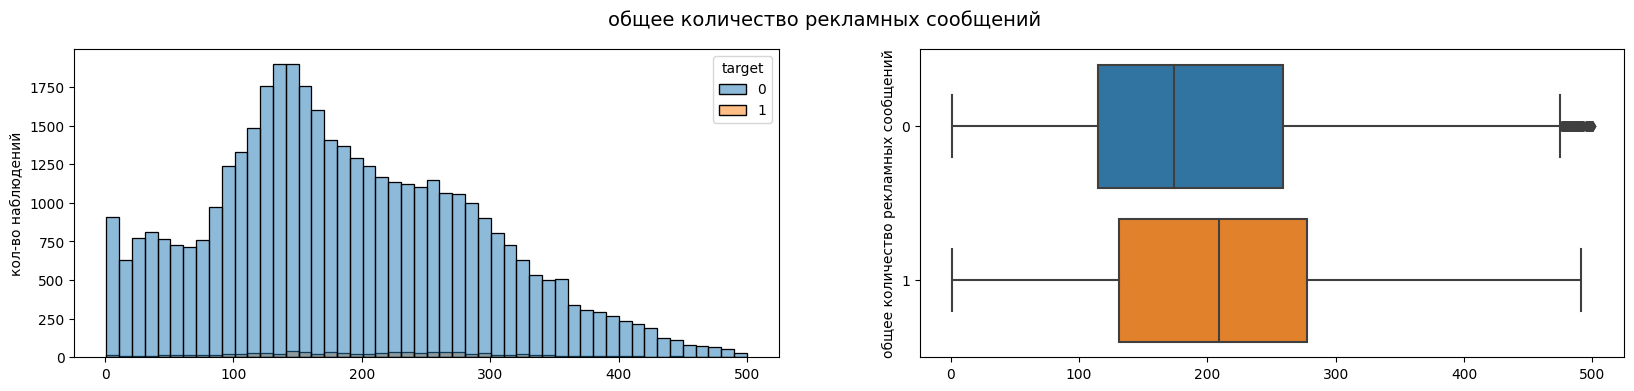

In [139]:
initial_data_analisys_numeric(df_target[df_target['total_messages'] <= 500], 'total_messages', split_column = 'target', selected_bins = 50)

доля электронных писем в рассылках() - описательные статистики



count    41982.000000
mean         0.509519
std          0.394641
min          0.000000
25%          0.059695
50%          0.479268
75%          1.000000
max          1.000000
Name: email, dtype: float64

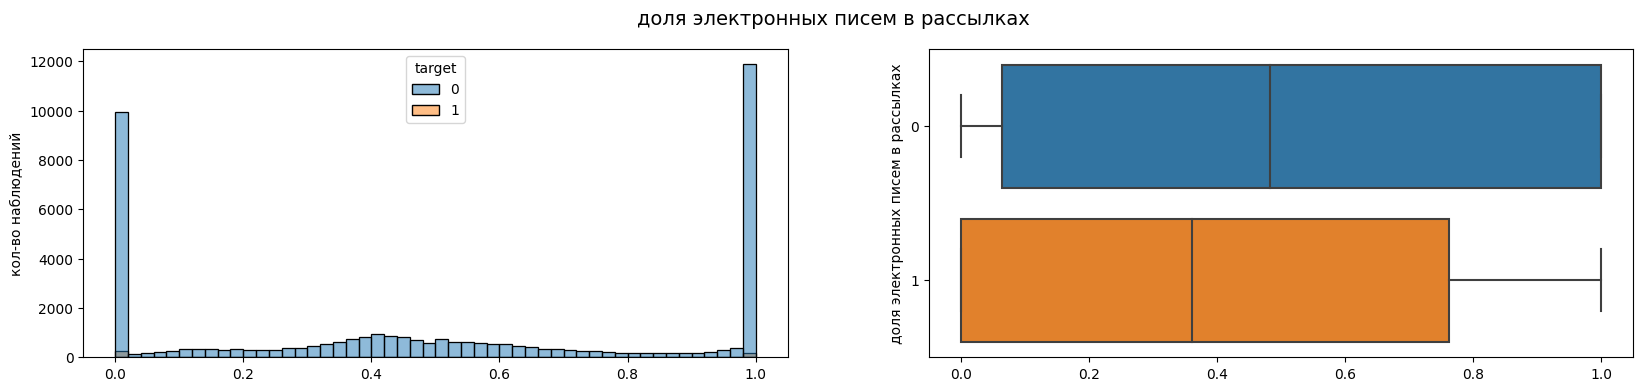

In [140]:
initial_data_analisys_numeric(df_target, 'email', split_column = 'target', selected_bins = 50)

### Корреляционный анализ

С учетом значительного количества категориальных признаков будем использовать корреляцию $\phi_k$.

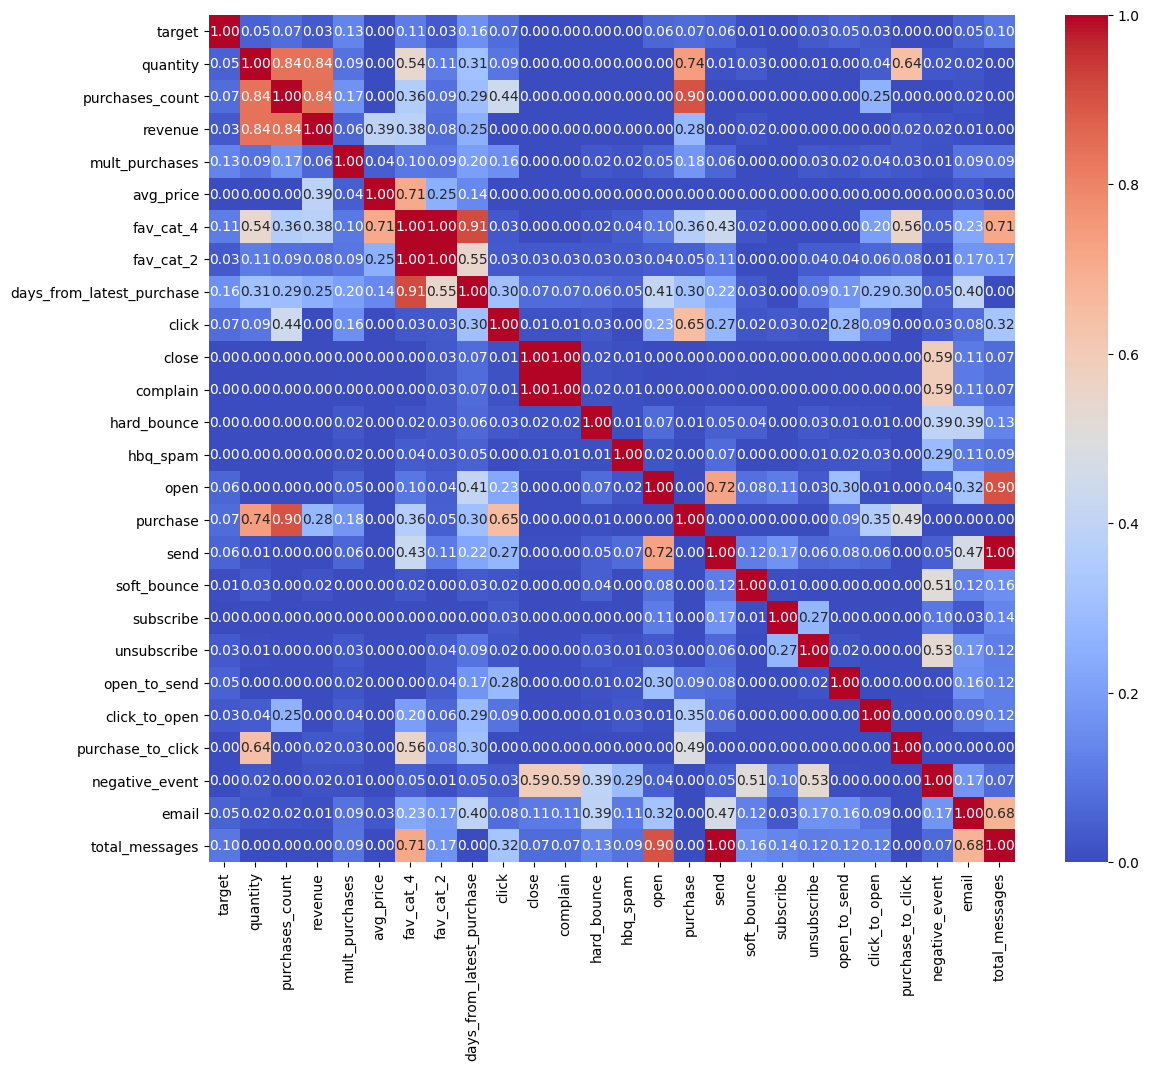

In [141]:
interval_columns = ['quantity', 'purchases_count', 'revenue', 'avg_price', 'click', 'open', 'purchase', 'send',
                   'open_to_send', 'click_to_open', 'purchase_to_click', 'email']

phi = df_target[df_target.columns.tolist()[1:]].phik_matrix(
    interval_cols = interval_columns
)
fig, ax = plt.subplots(figsize=(13,11))
sns.heatmap(phi, annot=True, fmt='.2f', cmap='coolwarm', ax = ax);

**Выводы:**
* Целевой признак наиболее сильно коррелирует с признаками:
    * `days_from_latest_purchase` - количество дней, прошебшее с последней покупки
    * `mult_purchases` - несколько покупок
    * `fav_cat_4` - любимая категоря
    * `purchase` и `purchases_count` - количество покупок
* Коэффициент корреляции равен 1 для признаков:
    * `send` и `total_messages`, т.к. это один и тот же признак
    * `fav_cat_4` и `fav_cat_2`, т.к. признаки описывают одну и ту же информацию с разным уровнем детализации
    * `close` и `complain` - редкия действия, совершенные одним и тем же покупателем
* Высокий коэффициент корреляции:
    * `purchase` и `purchases_count`, т.к. это один и тот же признак, который был получен из двух разных источников
    * `purchases_count` и `revenue`
    * `purchases_count` и `quantity`

## Выбор оптимальной модели

In [142]:
df_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49849 entries, 0 to 49848
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   client_id                  49849 non-null  int64  
 1   target                     49849 non-null  int64  
 2   quantity                   49849 non-null  int64  
 3   purchases_count            49849 non-null  int64  
 4   revenue                    49849 non-null  float64
 5   mult_purchases             49849 non-null  int64  
 6   avg_price                  49849 non-null  float64
 7   fav_cat_4                  49849 non-null  object 
 8   fav_cat_2                  49849 non-null  object 
 9   days_from_latest_purchase  49849 non-null  int64  
 10  click                      41982 non-null  float64
 11  close                      41982 non-null  float64
 12  complain                   41982 non-null  float64
 13  hard_bounce                41982 non-null  flo

Обратим внимание, что при объединении таргета с агрегированными данными о маркетинговой коммуникации возникли пропуски. Будем обрабатывать пропуски в пайплайне при обучении модели.

### Обучающая и тестовая выборка

Исключим признаки 
* `close`, `complain`, `hard_bounce`, `hbq_spam`, `soft_bounce`, `unsubscribe`, т.к. информация все негативные действия пользователя описываются признаком `negative_event`
* `subscribe`, т.к. это редкое действие, не коррелирующее с таргетом
* `purchases_count`, `total_messages`, т.к. эти признаки дублируют уже существующие признаки
* `fav_cat_2` из-за корреляции с `fav_cat_4`

In [143]:
X_train, X_test, y_train, y_test = train_test_split(
    df_target.drop(['client_id', 
                    'close', 'complain', 'hard_bounce', 'hbq_spam', 
                    'soft_bounce', 'unsubscribe',
                    'subscribe',
                    'purchases_count',
                    'total_messages',
                    'fav_cat_2'
                   ], axis = 1).drop_duplicates().drop(['target'], axis=1),
    df_target.drop(['client_id', 
                    'close', 'complain', 'hard_bounce', 'hbq_spam', 
                    'soft_bounce', 'unsubscribe',
                    'subscribe',
                    'purchases_count',
                    'total_messages',
                    'fav_cat_2'
                   ], axis = 1).drop_duplicates()['target'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df_target.drop(['client_id', 
                    'close', 'complain', 'hard_bounce', 'hbq_spam', 
                    'soft_bounce', 'unsubscribe',
                    'subscribe',
                    'purchases_count',
                    'total_messages',
                    'fav_cat_2'
                              ], axis = 1).drop_duplicates()['target']
)

### Подготовка данных

Проведем подготовку данных с учетом наличия пропущенных значений и потребности в масштабировании количественных переменных.

Для масштабирования количественных данных будем использовать скейлер `MinMaxScaler()`, т.к. признаки не харектеризуются нормальным распределением. 

Пропуски в категориальных признаках будем заполнять самым частым значением, в количественных признаках - медианой.

Для обработки данных и обучения моделей будем использовать пайплайны.

In [144]:
ord_columns = ['fav_cat_4',
               #'fav_cat_2'
              ]

binary_columns = ['mult_purchases', 
                  #'subscribe',
                  #'close', 'complain', 'hard_bounce', 'hbq_spam', 'soft_bounce', 'unsubscribe',
                  'negative_event'
                 ]

num_columns = [item for item in X_train.select_dtypes(include=np.number).columns.tolist() if item not in binary_columns]

In [145]:
categories_4 = sorted(X_train['fav_cat_4'].unique())

In [146]:
#categories_2 = sorted(X_train['fav_cat_2'].unique())

In [147]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    categories_4, 
                    #categories_2,
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [148]:
bin_pipe = Pipeline(
    [
        ('simpleImputer_binary', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [149]:
num_pipe = Pipeline(
    [
        ('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='median')),
        ('scaler', MinMaxScaler())
    ]
)

In [150]:
data_transformer = ColumnTransformer(
    [('ord', ord_pipe, ord_columns),
     ('bin', bin_pipe, binary_columns),
     ('num', num_pipe, num_columns)
    ], 
    remainder='passthrough'
)

### Выбор метрики
Целевая метрика: **ROC-AUC**. 

Критерий успеха: ROC-AUC не меньше 0,7.

In [151]:
scoring = {
    'roc_auc_score': 'roc_auc',
    'accuracy_score': 'accuracy'
}

### Логистическая регрессия

Подбор гиперпараметров для всех моделей будем осуществлять с использованием `RandomizedSearchCV`.

### Обучение модели

In [152]:
pipe_reg = Pipeline([
    ('preprocessor', data_transformer),
    ('models',  LogisticRegression(random_state=RANDOM_STATE, solver='saga', class_weight = 'balanced'))
])

In [153]:
param_grid = [
    
     # словарь для модели LogisticRegression()
    {
        'models__penalty' : ['l1', 'l2'],
        'models__C' : range(1, 6),
    },
   
]

In [154]:
random_search_reg = RandomizedSearchCV(
    pipe_reg, 
    param_grid,
    scoring=scoring,
    refit = 'roc_auc_score',
    cv=5,
    n_iter=150,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
random_search_reg.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ord',
                                                                               Pipeline(steps=[('simpleImputer_before_ord',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ord',
                                                                                                OrdinalEncoder(categories=[["['1', "
                                                                                                                            "'22', "
                                                                                                                            "'50', "
                                                                                                                            "'685']",
                                                                                                                            "['2', "
                                                                                                                            "'17', "
                                                                                                                            "'107', "
                                                                                                                            "'453']",
                                                                                                                            "['2', "
                                                                                                                            "'17', "
                                                                                                                            "'137', "
                                                                                                                            "'469']",
                                                                                                                            "['2', "
                                                                                                                            "'...
                                                                                'open_to_send',
                                                                                'click_to_open',
                                                                                'purchase_to_click',
                                                                                'email'])])),
                                             ('models',
                                              LogisticRegression(class_weight='balanced',
                                                                 random_state=42,
                                                                 solver='saga'))]),
                   n_iter=150, n_jobs=-1,
                   param_distributions=[{'models__C': range(1, 6),
                                         'models__penalty': ['l1', 'l2']}],
                   random_state=42, refit='roc_auc_score',
                   scoring={'accuracy_score': 'accuracy',
                            'roc_auc_score': 'roc_auc'})

In [155]:
print(f'Среднее значение ROC_AUC при кросс-валидации {random_search_reg.best_score_:.2f}')
y_pred_proba = random_search_reg.predict_proba(X_train)
print(f'Значение метрики ROC-AUC на обучающей выборке {roc_auc_score(y_train, y_pred_proba[:,1]):.2f}')

Среднее значение ROC_AUC при кросс-валидации 0.67
Значение метрики ROC-AUC на обучающей выборке 0.64


### Значимые признаки

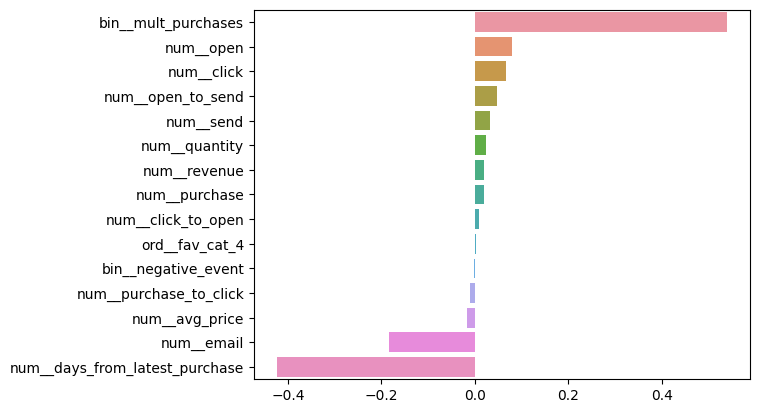

In [156]:
importances = pd.Series(
    data = random_search_reg.best_estimator_.named_steps['models'].coef_[0],
    index=random_search_reg.best_estimator_.named_steps['preprocessor'].get_feature_names_out(),
).sort_values(ascending = False)
sns.barplot(y = importances.index, x = importances.values, orient='h');

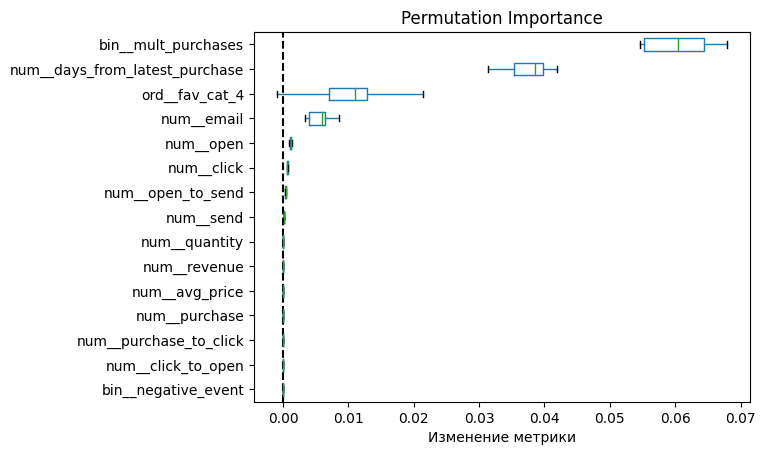

In [157]:
check_importance(search_result = random_search_reg, X_test = X_train, y_test = y_train, scoring = 'roc_auc')

#### Выводы:
* Критерий успеха по метрике ROC-AUC не достигается, что может быть связано с наличием выбросов в данных и/или наличием нелинейных зависимостей
* Значимые признаки:
  * Несколько покупок
  * Количество дней, прошедшее с последней покупки
  * Любимая категория
  * Доля электронных писем в маркетинговой коммуникации

### Модель Decision Tree

#### Обучение модели

In [158]:
pipe_dt = Pipeline([
    ('preprocessor', data_transformer),
    ('models',  DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight = 'balanced'))
])

In [159]:
param_grid = [
    
     # словарь для модели DecisionTreeClassifier()
    {
        'models__max_depth': range(2, 30),
        'models__max_features': range(2, 6),
        'models__min_samples_split': range(2, 6)
    }
   
]

In [160]:
random_search_dt = RandomizedSearchCV(
    pipe_dt, 
    param_grid,
    scoring=scoring,
    refit = 'roc_auc_score',
    cv=5,
    n_iter=150,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
random_search_dt.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ord',
                                                                               Pipeline(steps=[('simpleImputer_before_ord',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ord',
                                                                                                OrdinalEncoder(categories=[["['1', "
                                                                                                                            "'22', "
                                                                                                                            "'50', "
                                                                                                                            "'685']",
                                                                                                                            "['2', "
                                                                                                                            "'17', "
                                                                                                                            "'107', "
                                                                                                                            "'453']",
                                                                                                                            "['2', "
                                                                                                                            "'17', "
                                                                                                                            "'137', "
                                                                                                                            "'469']",
                                                                                                                            "['2', "
                                                                                                                            "'...
                                                                                'purchase_to_click',
                                                                                'email'])])),
                                             ('models',
                                              DecisionTreeClassifier(class_weight='balanced',
                                                                     random_state=42))]),
                   n_iter=150, n_jobs=-1,
                   param_distributions=[{'models__max_depth': range(2, 30),
                                         'models__max_features': range(2, 6),
                                         'models__min_samples_split': range(2, 6)}],
                   random_state=42, refit='roc_auc_score',
                   scoring={'accuracy_score': 'accuracy',
                            'roc_auc_score': 'roc_auc'})

In [161]:
print(f'Среднее значение ROC_AUC при кросс-валидации {random_search_dt.best_score_:.2f}')
y_pred_proba = random_search_dt.predict_proba(X_train)
print(f'Значение метрики ROC-AUC на обучающей выборке {roc_auc_score(y_train, y_pred_proba[:,1]):.2f}')

Среднее значение ROC_AUC при кросс-валидации 0.68
Значение метрики ROC-AUC на обучающей выборке 0.74


#### Значимые признаки

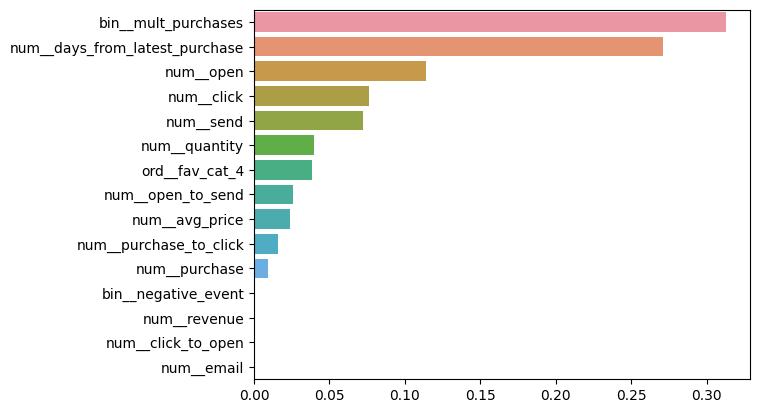

In [162]:
importances = pd.Series(
    data = random_search_dt.best_estimator_.named_steps['models'].feature_importances_,
    index=random_search_dt.best_estimator_.named_steps['preprocessor'].get_feature_names_out(),
).sort_values(ascending = False)
sns.barplot(y = importances.index, x = importances.values, orient='h');

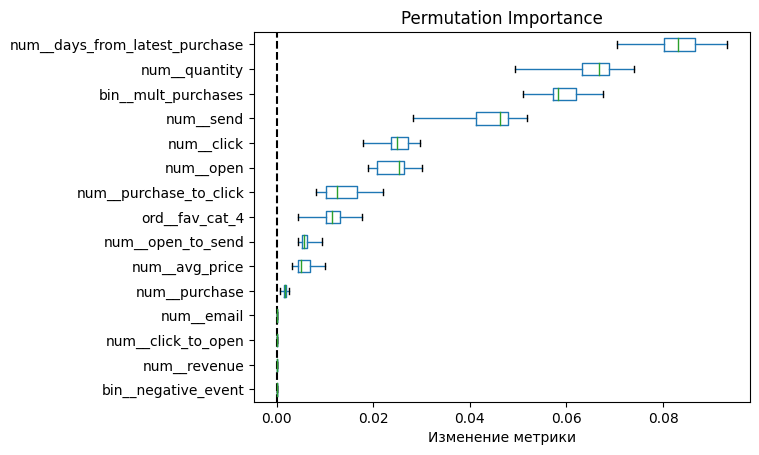

In [163]:
check_importance(search_result = random_search_dt, X_test = X_train, y_test = y_train, scoring = 'roc_auc')

#### Выводы:
* Критерий успеха по метрике ROC-AUC не достигнут при кросс-валидации
* Ключевые значимые признаки:
  * Количество дней, прошедшее с последней покупки
  * Количество единиц товара
  * Несколько покупок
  * Количество отправленных рекламных сообщений

### Модель kNN

In [164]:
pipe_knn = Pipeline([
    ('preprocessor', data_transformer),
    ('models',  KNeighborsClassifier())
])

In [165]:
param_grid = [
    
     # словарь для модели KNeighborsClassifier()
    {
        'models__n_neighbors': range(2, 8),
        'models__weights': ['uniform', 'distance']
    }
   
]

In [166]:
random_search_knn = RandomizedSearchCV(
    pipe_knn, 
    param_grid,
    scoring=scoring,
    refit = 'roc_auc_score',
    cv=5,
    n_iter=15,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
random_search_knn.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ord',
                                                                               Pipeline(steps=[('simpleImputer_before_ord',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ord',
                                                                                                OrdinalEncoder(categories=[["['1', "
                                                                                                                            "'22', "
                                                                                                                            "'50', "
                                                                                                                            "'685']",
                                                                                                                            "['2', "
                                                                                                                            "'17', "
                                                                                                                            "'107', "
                                                                                                                            "'453']",
                                                                                                                            "['2', "
                                                                                                                            "'17', "
                                                                                                                            "'137', "
                                                                                                                            "'469']",
                                                                                                                            "['2', "
                                                                                                                            "'...
                                                                                'click',
                                                                                'open',
                                                                                'purchase',
                                                                                'send',
                                                                                'open_to_send',
                                                                                'click_to_open',
                                                                                'purchase_to_click',
                                                                                'email'])])),
                                             ('models',
                                              KNeighborsClassifier())]),
                   n_iter=15, n_jobs=-1,
                   param_distributions=[{'models__n_neighbors': range(2, 8),
                                         'models__weights': ['uniform',
                                                             'distance']}],
                   random_state=42, refit='roc_auc_score',
                   scoring={'accuracy_score': 'accuracy',
                            'roc_auc_score': 'roc_auc'})

In [167]:
print(f'Среднее значение ROC_AUC при кросс-валидации {random_search_knn.best_score_:.2f}')
y_pred_proba = random_search_knn.predict_proba(X_train)
print(f'Значение метрики ROC-AUC на обучающей выборке {roc_auc_score(y_train, y_pred_proba[:,1]):.2f}')

Среднее значение ROC_AUC при кросс-валидации 0.56
Значение метрики ROC-AUC на обучающей выборке 1.00


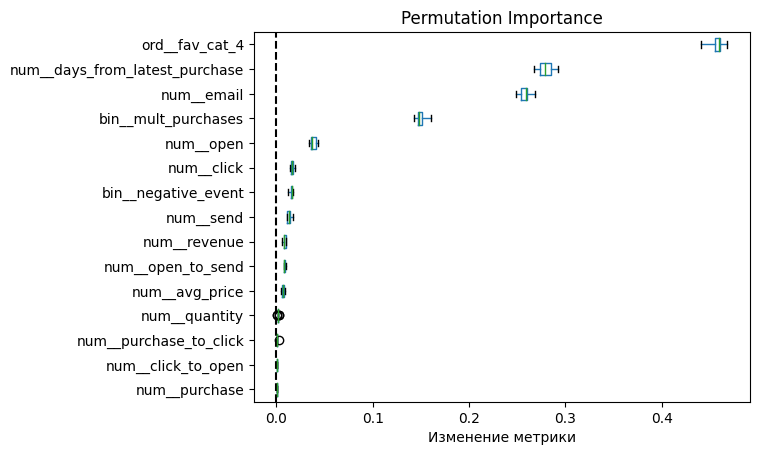

In [168]:
check_importance(search_result = random_search_knn, X_test = X_train, y_test = y_train, scoring = 'roc_auc')

#### Выводы:
* Критерий успеха по метрике ROC-AUC не достигается при кросс-валидации
  * Любимая категория
  * Количество дней, прошедшее с последней покупки
  * Доля электронных писем в маркетинговой коммуникации
  * Несколько покупок

### Градиентный бустинг

#### Обучение модели

In [169]:
pipe_boost = Pipeline([
    ('preprocessor', data_transformer),
    ('models', lgb.LGBMClassifier(random_state=RANDOM_STATE, class_weight = 'balanced'))
])

In [170]:
param_grid = [
    {
        'models__learning_rate': [0.05, 0.1],
        'models__num_leaves' : [30, 50],
        'models__max_depth' : [-1, 5, 10],
        'models__n_estimators' : [80, 100, 200]
    }
]

In [171]:
random_search_boost = RandomizedSearchCV(
    pipe_boost, 
    param_grid,
    scoring=scoring,
    refit = 'roc_auc_score',
    cv=5,
    n_iter=36,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
random_search_boost.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 769, number of negative: 39051
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2672
[LightGBM] [Info] Number of data points in the train set: 39820, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ord',
                                                                               Pipeline(steps=[('simpleImputer_before_ord',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ord',
                                                                                                OrdinalEncoder(categories=[["['1', "
                                                                                                                            "'22', "
                                                                                                                            "'50', "
                                                                                                                            "'685']",
                                                                                                                            "['2', "
                                                                                                                            "'17', "
                                                                                                                            "'107', "
                                                                                                                            "'453']",
                                                                                                                            "['2', "
                                                                                                                            "'17', "
                                                                                                                            "'137', "
                                                                                                                            "'469']",
                                                                                                                            "['2', "
                                                                                                                            "'...
                                                                                'email'])])),
                                             ('models',
                                              LGBMClassifier(class_weight='balanced',
                                                             random_state=42))]),
                   n_iter=36, n_jobs=-1,
                   param_distributions=[{'models__learning_rate': [0.05, 0.1],
                                         'models__max_depth': [-1, 5, 10],
                                         'models__n_estimators': [80, 100, 200],
                                         'models__num_leaves': [30, 50]}],
                   random_state=42, refit='roc_auc_score',
                   scoring={'accuracy_score': 'accuracy',
                            'roc_auc_score': 'roc_auc'})

In [172]:
print(f'Среднее значение ROC_AUC при кросс-валидации {random_search_boost.best_score_:.2f}')
y_pred_proba = random_search_boost.predict_proba(X_train)
print(f'Значение метрики ROC-AUC на обучающей выборке {roc_auc_score(y_train, y_pred_proba[:,1]):.2f}')

Среднее значение ROC_AUC при кросс-валидации 0.72
Значение метрики ROC-AUC на обучающей выборке 0.93


### Значимые признаки

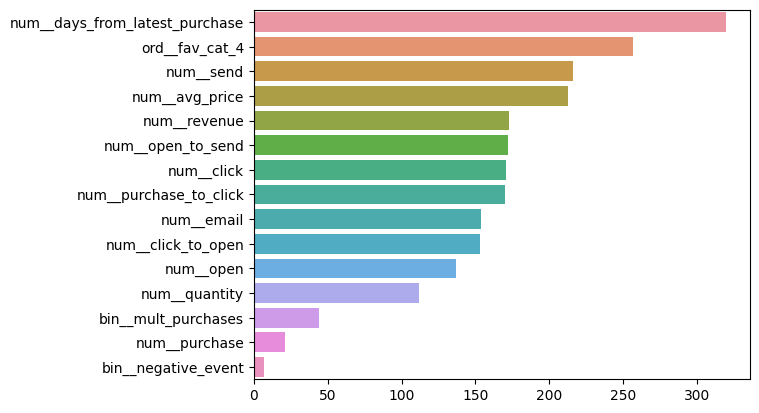

In [173]:
importances = pd.Series(
    data = random_search_boost.best_estimator_.named_steps['models'].feature_importances_,
    index=random_search_boost.best_estimator_.named_steps['preprocessor'].get_feature_names_out(),
).sort_values(ascending = False)
sns.barplot(y = importances.index, x = importances.values, orient='h');

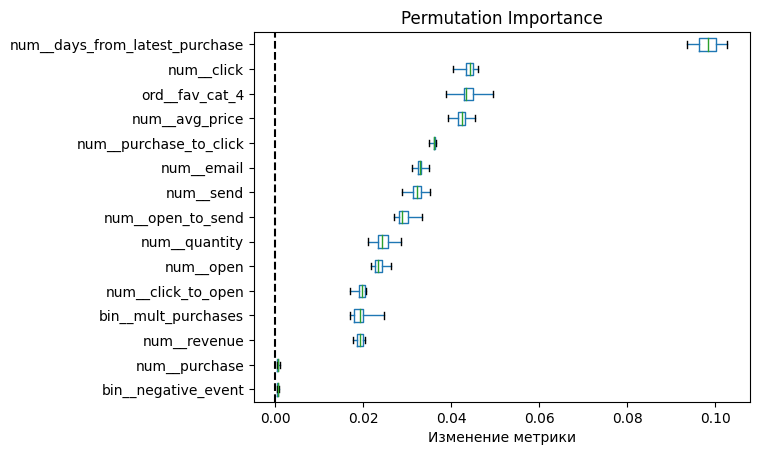

In [174]:
check_importance(search_result = random_search_boost, X_test = X_train, y_test = y_train, scoring = 'roc_auc')

#### Выводы:
* Достигнут критерий успеха по метрике ROC-AUC
* Ключевые значимые признаки:
  * Количество дней, прошедшее с последней покупки
  * Количество кликов
  * Любимая категория
  * Средняя цена единицы товара

### Оптимальная модель

Критерий успеха ROC-AUC >= 0.7 достигается для модели градиентного бустинга при кросс-валидации и на обучающей выборке, поэтому выберем модель градиентного бустинга как оптимальную.

### Тестирование оптимальной модели

In [175]:
y_pred_proba = random_search_boost.predict_proba(X_test)
print(f'Значение метрики ROC-AUC на тестовой выборке {roc_auc_score(y_test, y_pred_proba[:,1]):.2f}')

Значение метрики ROC-AUC на тестовой выборке 0.75


Критерий успеха ROC-AUC >= 0.7 достигается на тестовой выборке.

## Общий вывод

Исследование выполнено с целью предсказания вероятности, что покупатель совершит покупку в течение следующих 90 дней с учетом данных о предыдущих покупках и маркетенговых коммуникациях. 

Перед моделированием выполнен исследовательский анализ данных. В данных о покупках и в данных о рекламных сообщениях выявлены полные дубликаты. В данных о покупках дубликаты сохранены, т.к. предполагается, что покупатель в один день может совершить несколько покупок. Из данных о рекламных сообщениях полные дубликаты исключены, т.к. датафрейм содержит столбец с датой и временем с точностью до секунд, и предполагается, что одно и то же событие не может произойти за одну секунду дважды. 

В рамках исследовательского анализа выявлен значительный дисбаланс классов в целевом признаке, который учитывается при дальнейшем моделировании.

По результатам исследолвательского анализа выработан подход к формированию агрегированных признаков для моделирования для каждого из покупателей. Также выполнен корреляционный анализ с использованием $\phi_k$, по результатам которого отобраны признаки, наиболее сильно влияющие на целевой признак. Для моделирования использованы следующие признаки по каждому из покупателей:
* Характеристики покупательского поведения:
    * Общее количество купленных единиц товарра
    * Суммарная выручка
    * Несколько покупок (бинарный признак)
    * Средняя цена единицы товара
    * Любимая категория товаров
    * Количество дней, прошедших с последней покупки
* Зарактеристики рекламных рассылок и действий с ними:
    * Количество отправленных сообщений
    * Количество открытых сообщений
    * Количество кликов
    * Количество покупок
    * Отношение открытых сообщений к отправленным сообщениям
    * Отношение кликов к открытым сообщениям
    * Отношение покупок к кликам
    * Были ли негативные действия с сообщениями (бинарный признак)
    * Доля электронных писем в рекламных рассылках

При формировании агригированных признаков, характеризующих маркетинговую коммуникацию выявлено, что информация о рекламных собщениях есть не для всех целевых для исследования покупателей. Это учитывалось при подготовке данных к моделированию: пропущенные данные были заполнены самым частым значением для категориальных признаков, и медианными значениями для количественных признаков. Для стандартизации количественных данных использован `MinMaxScaler`. 

В рамках исследования рассмотрены следующие модели:
* логистическая регрессия (`LogisticRegression`)
* дерево решений (`DecisionTreeClassifier`)
* k ближайших соседей (`KNeighborsClassifier`)
* градиентный бустинг (`LGBMClassifier`)

Для каждой модели подбор гиперпараметров осуществлялся с помощью `RandomizedSearchCV`. В качестве целевой метрики задана метрика ROC-AUC. Критерий успеха ROC-AUC <= 0,7. Также на этапе моделирования для каждой из моделей выявлены ключевые значимые признаки, в том числе с использованием метода Permutation importance.

Критерию успеха при кросс-валидации соответствует модель градиентного бустинга, поэтому данныя модель была выбрана в качестве оптимальной и протестирована. 
* Значения метрики ROC-AUC:
    * При кросс-валидации 0.72
    * На обучающей выборке 0.93
    * На тестовой выборке 0.75
* Ключевые значимые признаки:
  * Количество дней, прошедшее с последней покупки
  * Количество кликов
  * Любимая категория
  * Средняя цена единицы товара
* Незначимые признаки:
    * Количество покупок
    * Были ли негативные действия с сообщениями (бинарный признак)

*Файл 'requirements.txt'*

In [176]:
#pip freeze > requirements.txt